In [2]:
import copy
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from src.models import get_true_and_pred_labels, plot_results, get_best_epoch, plot_confusion_matrix, plot_per_class_accuracy
from tqdm import tqdm
import math

import sys
sys.path.append('/repo')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Preparacion de Data

In [3]:
from src.models.FaceSentiment import undersample_imagefolder_dataset

import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Custom transform for histogram equalization
class HistogramEqualization:
    def __call__(self, img):
        # Convert PIL image to numpy array
        img_array = np.array(img)
        
        # Apply histogram equalization
        img_eq = cv2.equalizeHist(img_array)
        
        # Convert back to PIL image
        return Image.fromarray(img_eq)

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),  # Resize to 48x48
    HistogramEqualization(),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=0, scale=(1, 1.3)),  # Random zoom: 80% to 120% of the original size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    HistogramEqualization(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(root='./FerPlus/fer2013plus/fer2013/train/', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='./FerPlus/fer2013plus/fer2013/test/', transform=val_transforms)

# make underSample
train_dataset = undersample_imagefolder_dataset(train_dataset)
# val_dataset = undersample_imagefolder_dataset(val_dataset)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check if the DataLoader works as expected
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

class_names = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]


torch.Size([32, 1, 48, 48]) torch.Size([32])


## Entrenamiento de modelos

In [5]:
import copy
# Training function with CUDA checks
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, early_stoping=False):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'weights': [],
    }
    nanEcnounter = False
    
    for epoch in range(epochs):
        import gc
        torch.cuda.empty_cache()
        gc.collect()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        best_loss = float('inf')

        if nanEcnounter:
            break
        
        # Initialize tqdm progress bar for the training loop
        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for i, (inputs, labels) in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            if math.isnan(running_loss):
                nanEcnounter = True
                break
            
            # Update tqdm progress bar
            train_bar.set_postfix({
                'train_loss': running_loss / ((i + 1) * train_loader.batch_size),
                'train_acc': correct / total
            })

            # Free intermediate variables after each batch
            del inputs, labels, outputs, loss, predicted
            # torch.cuda.empty_cache()

        train_bar.clear()
        train_bar.close()

        epoch_loss = running_loss / len(train_loader.dataset)
        
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # Initialize variables for storing predictions and labels
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)

                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Free intermediate variables after each validation batch
                del inputs, labels, outputs, loss, predicted
                # torch.cuda.empty_cache()

        # Calculate loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        
        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Append metrics to history
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)
        history['weights'].append(copy.deepcopy(model.state_dict()))

        # Early Stopping
        if not early_stoping or epoch <= 5: continue
        if val_loss < best_loss:        
            best_loss = val_loss

        delta_loss = epoch_loss - val_loss
        delta_loss = delta_loss if delta_loss > 0 else 0

        delta_best_loss = best_loss - val_loss
        delta_best_loss = delta_best_loss if delta_best_loss > 0 else 0
        
        delta_loss = max(delta_loss, delta_best_loss)

        if delta_loss > 0.25:
            break

    return history


### Red Convolucional

Using device: cuda

--- testing model: CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
wd: None
----------------------------------


Best Validation F1 Score 0.5646982472570965, is for epoch 60


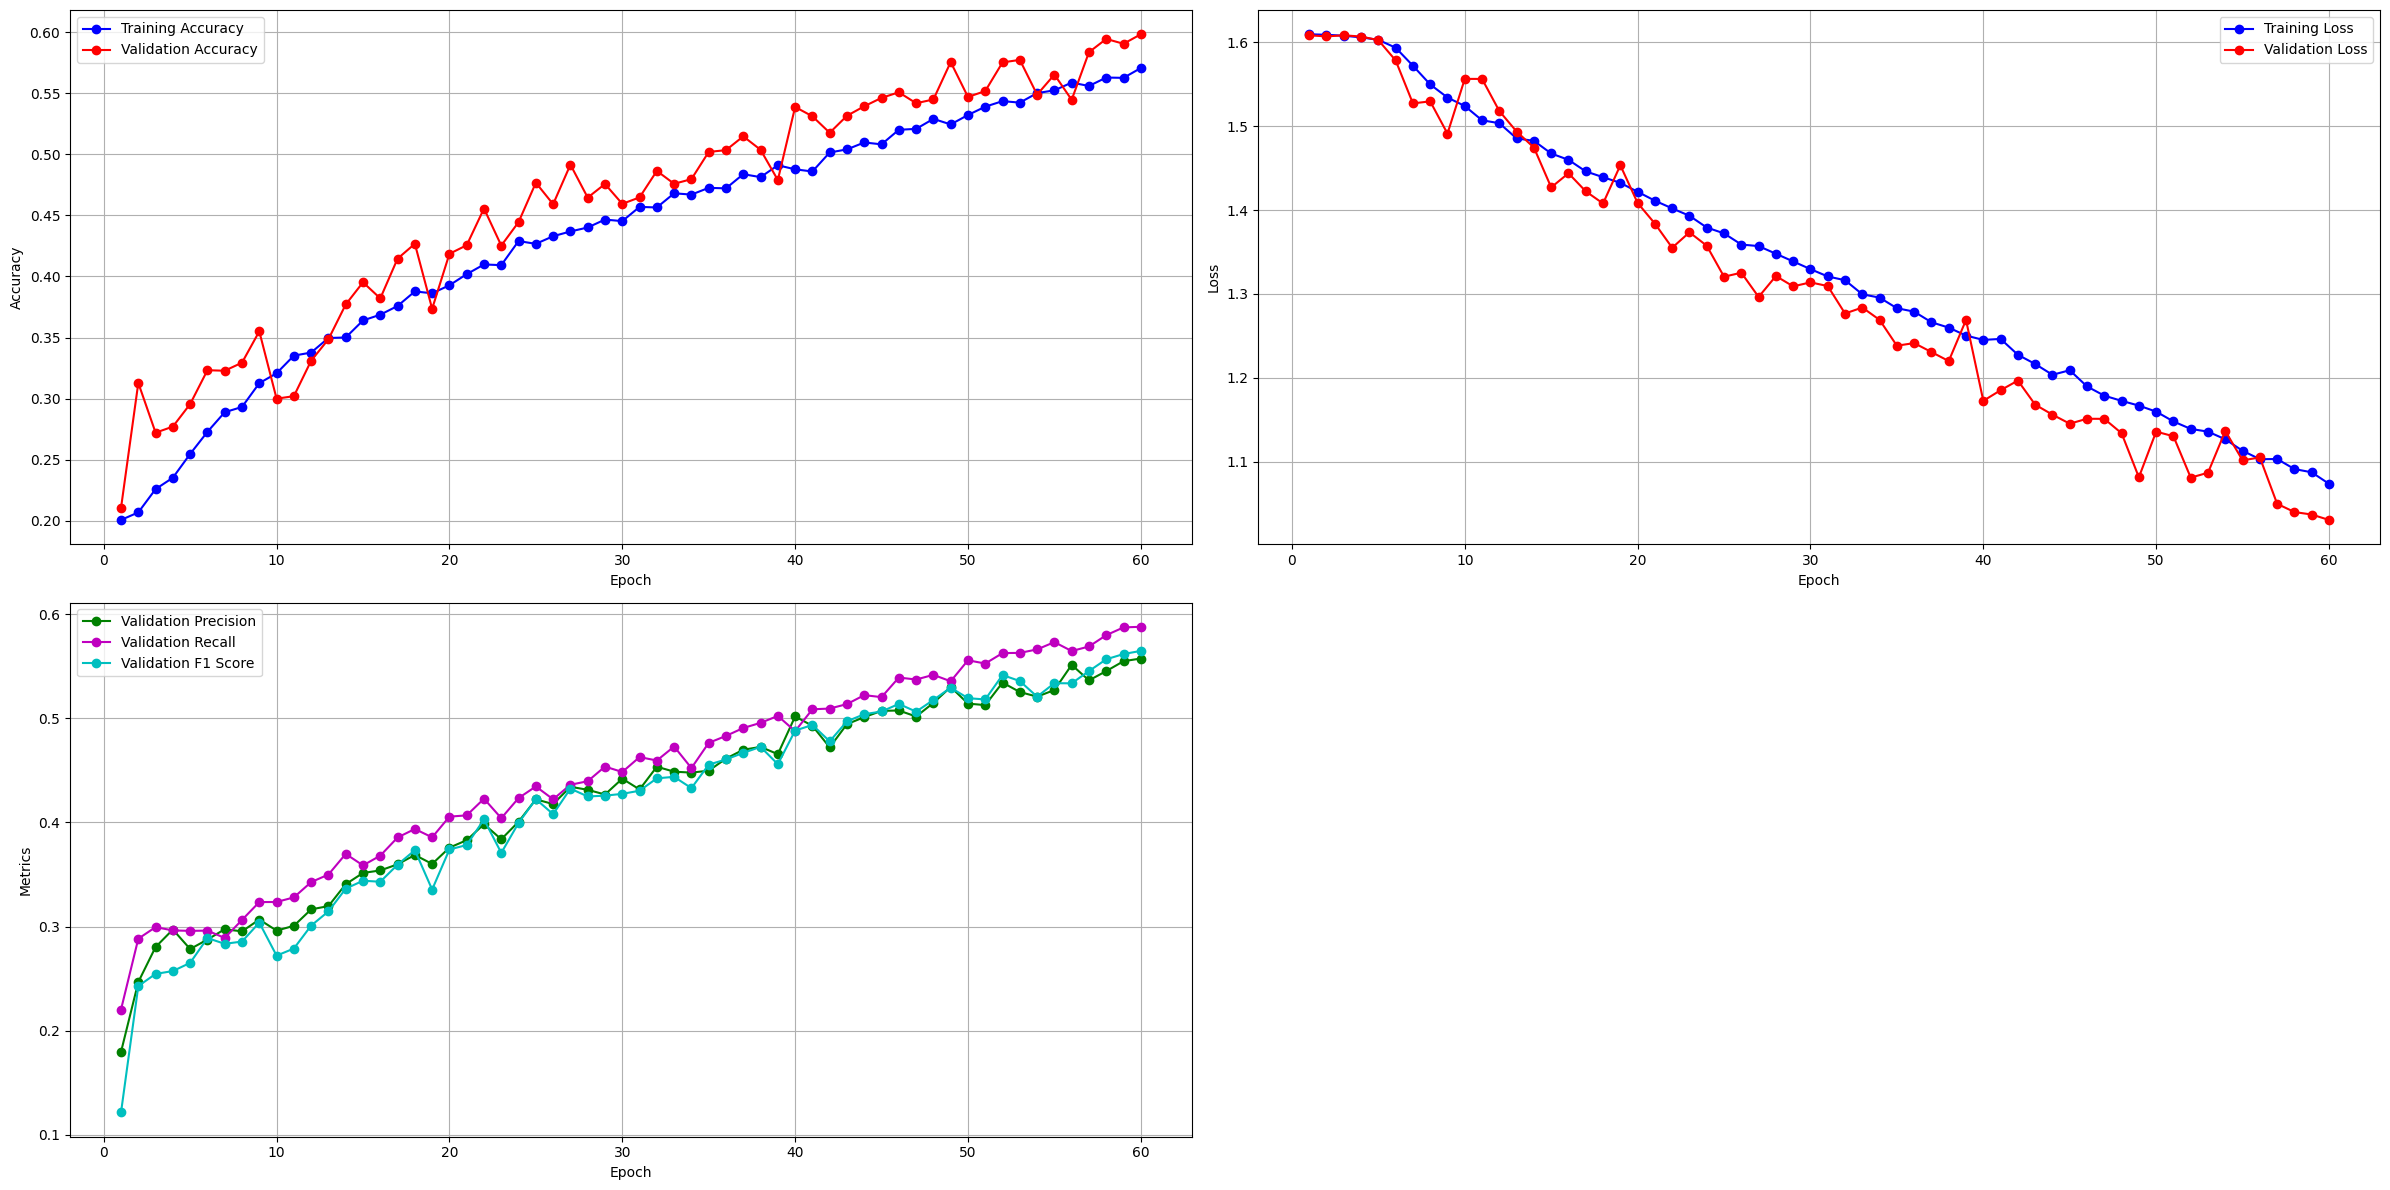

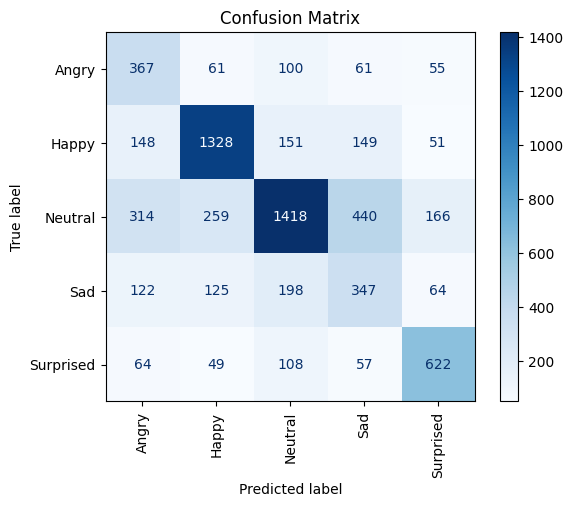

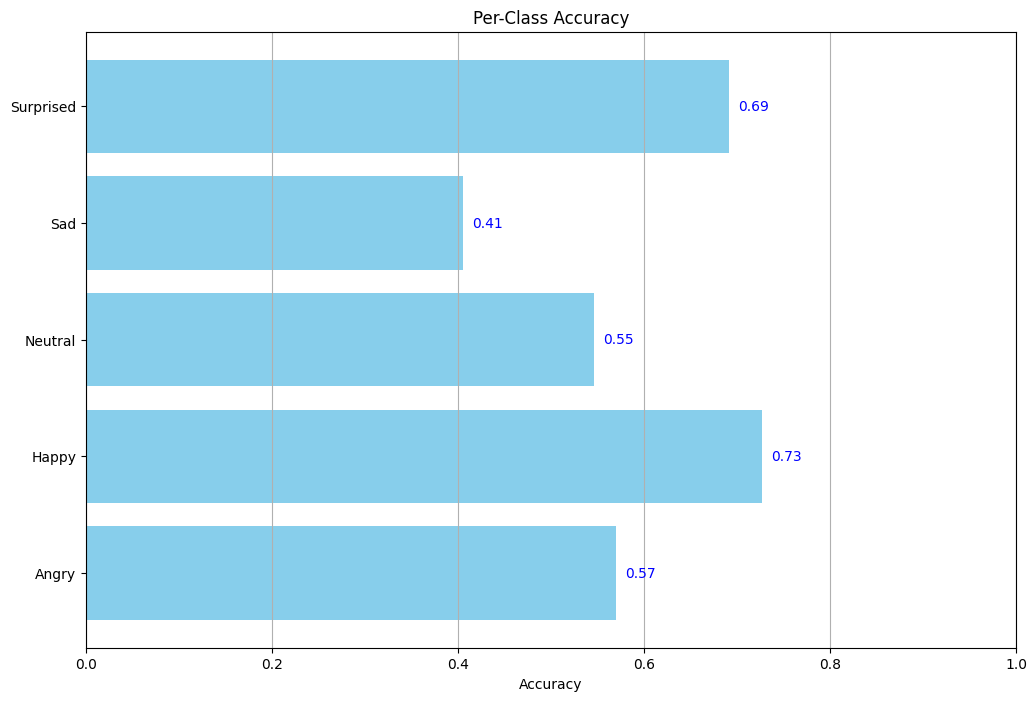


--- testing model: CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
wd: 0.01
----------------------------------


Best Validation F1 Score 0.4526900508737546, is for epoch 60


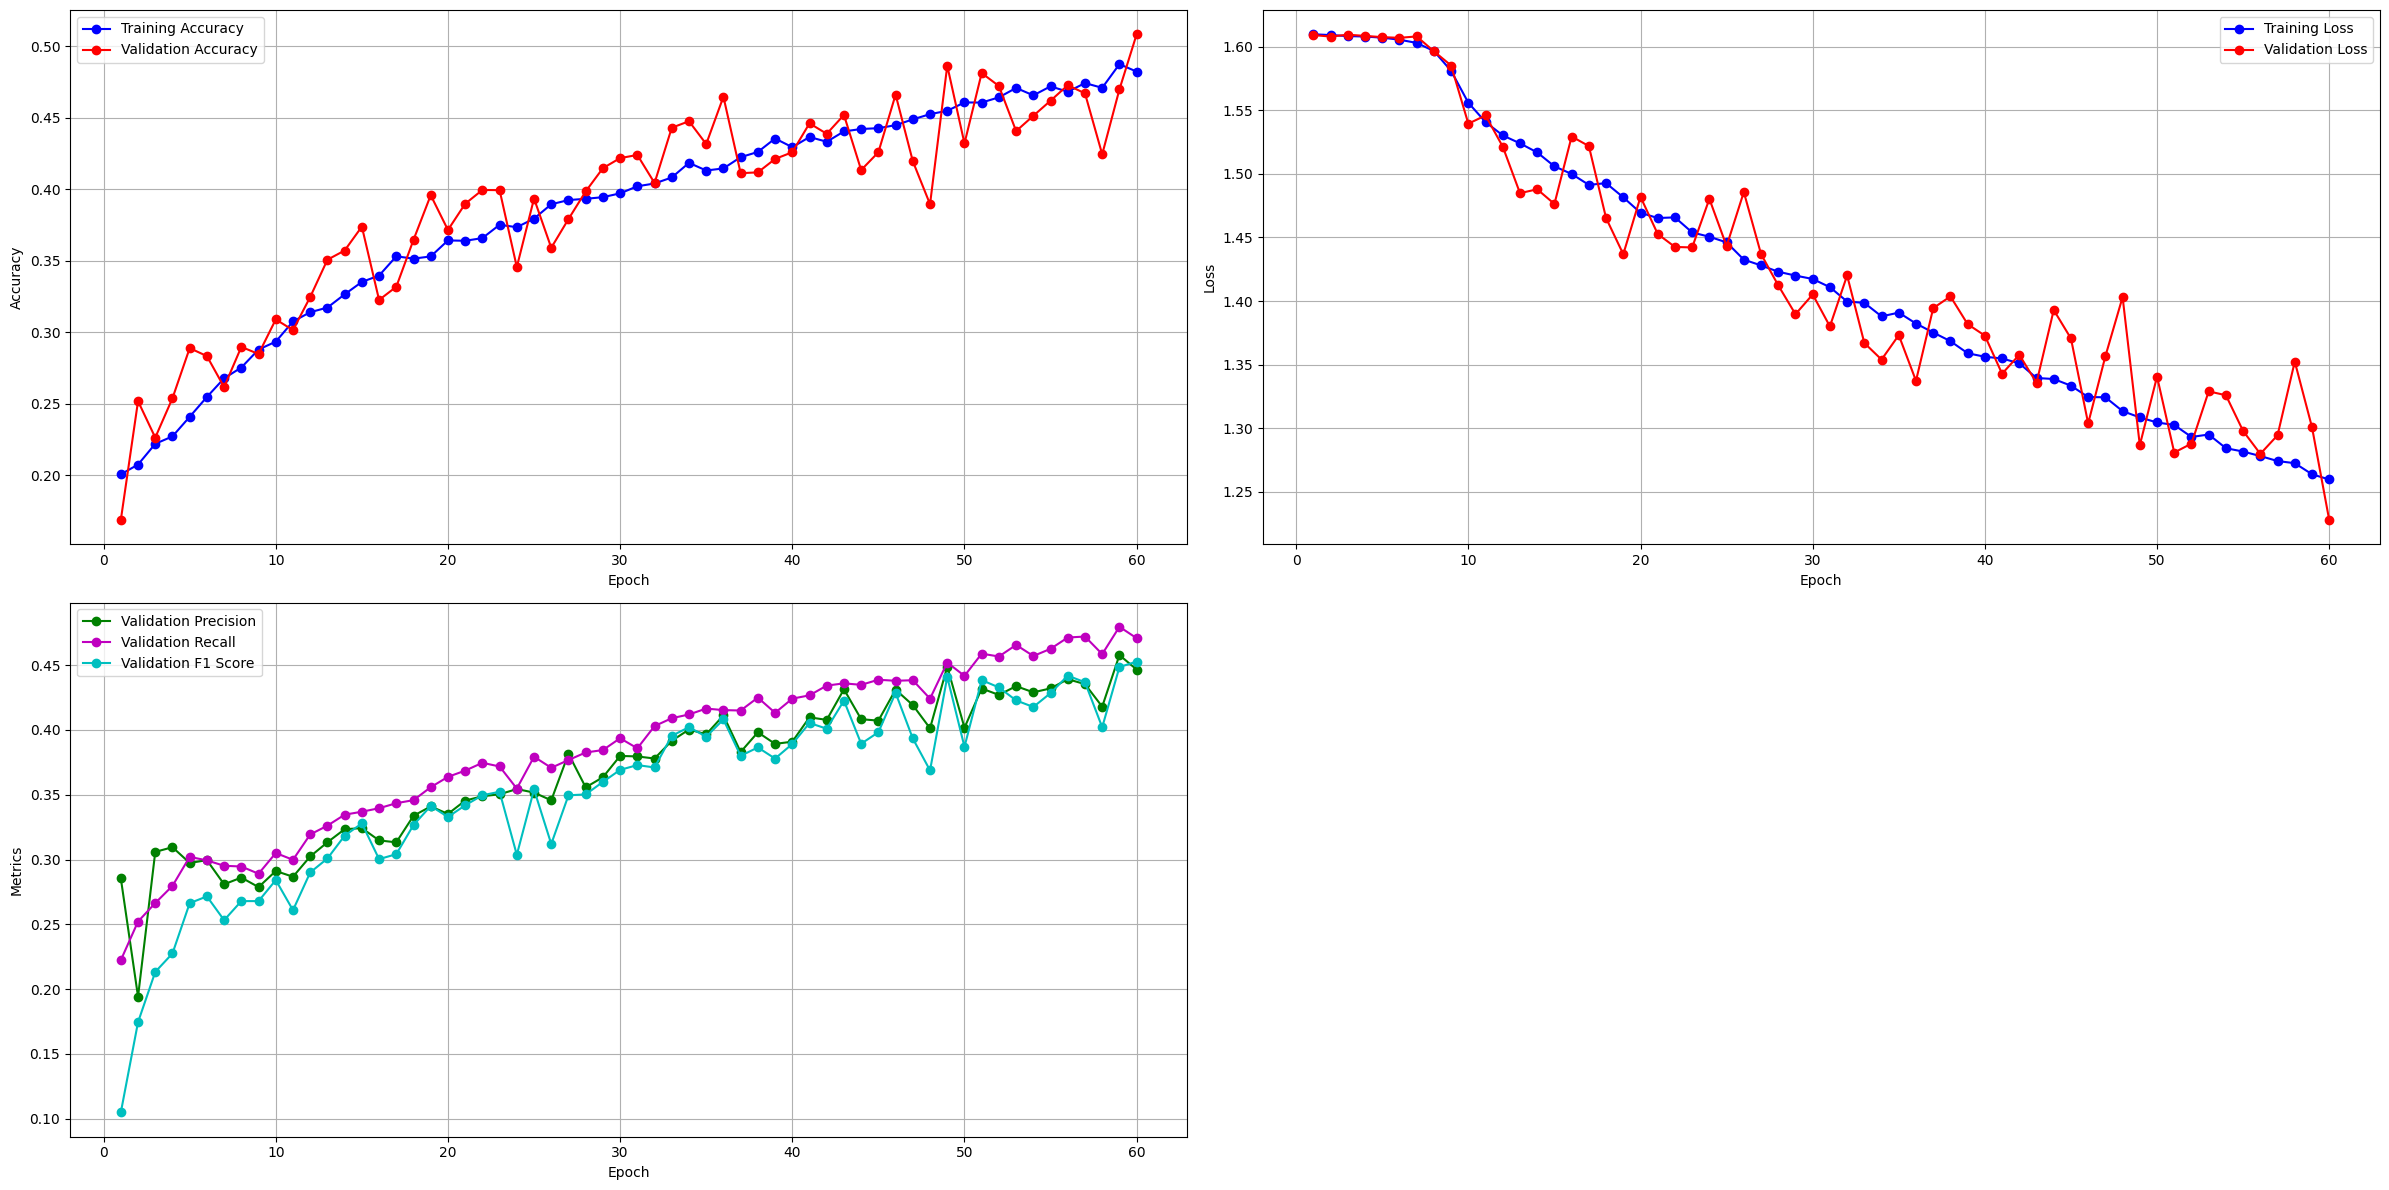

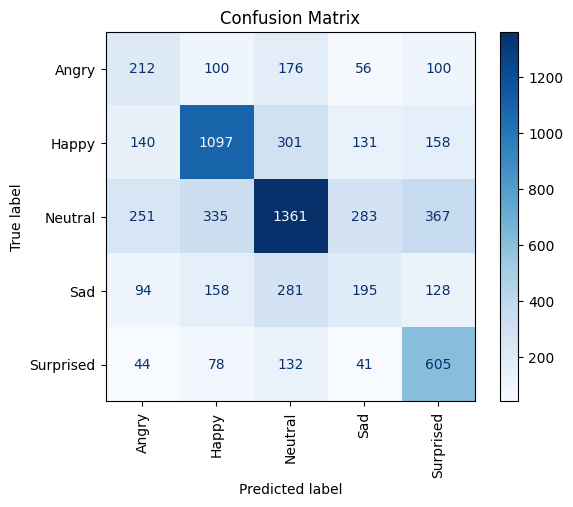

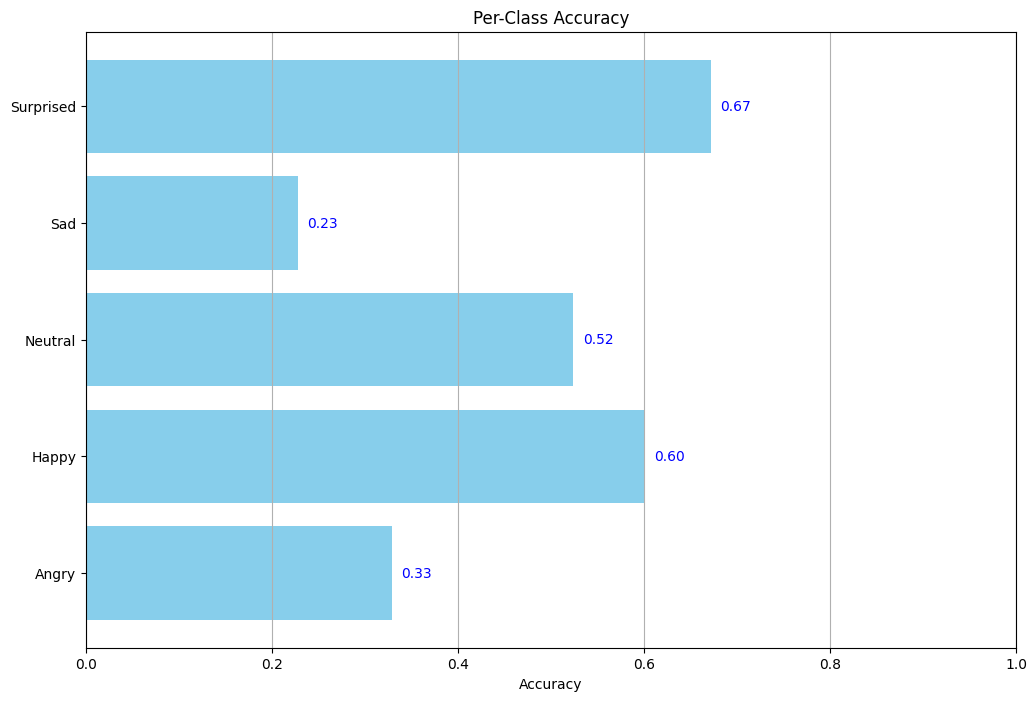


--- testing model: CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
wd: 0.001
----------------------------------


Best Validation F1 Score 0.5523819673514075, is for epoch 60


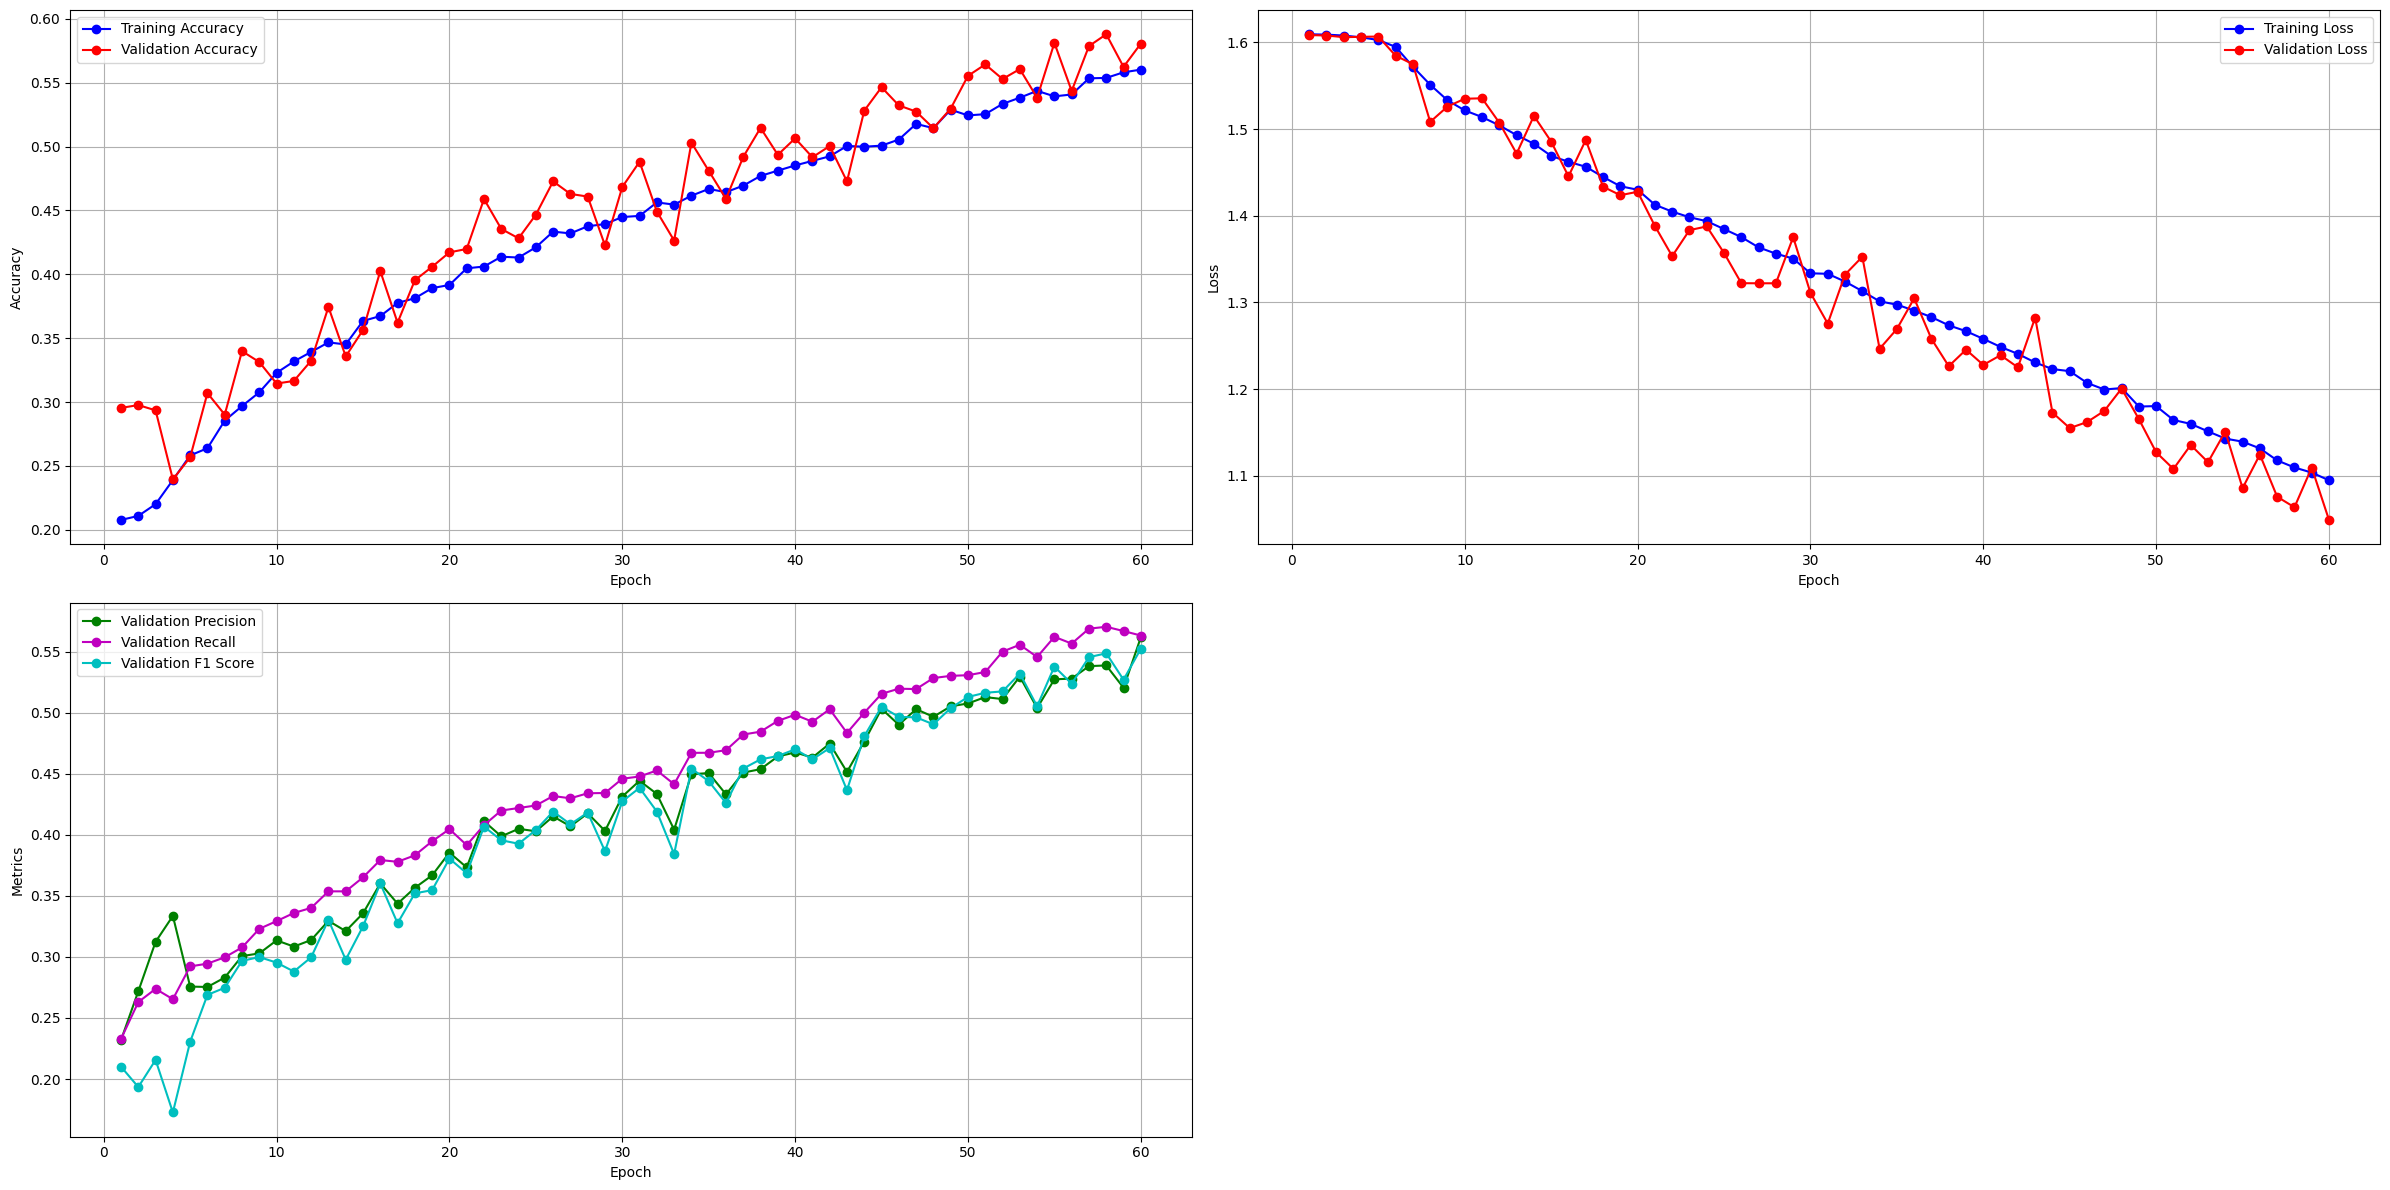

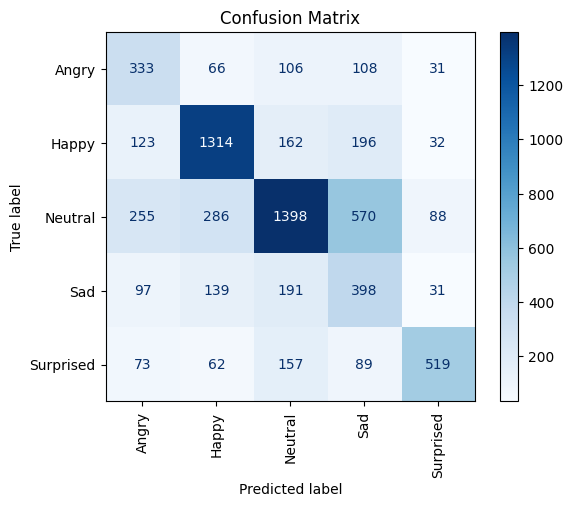

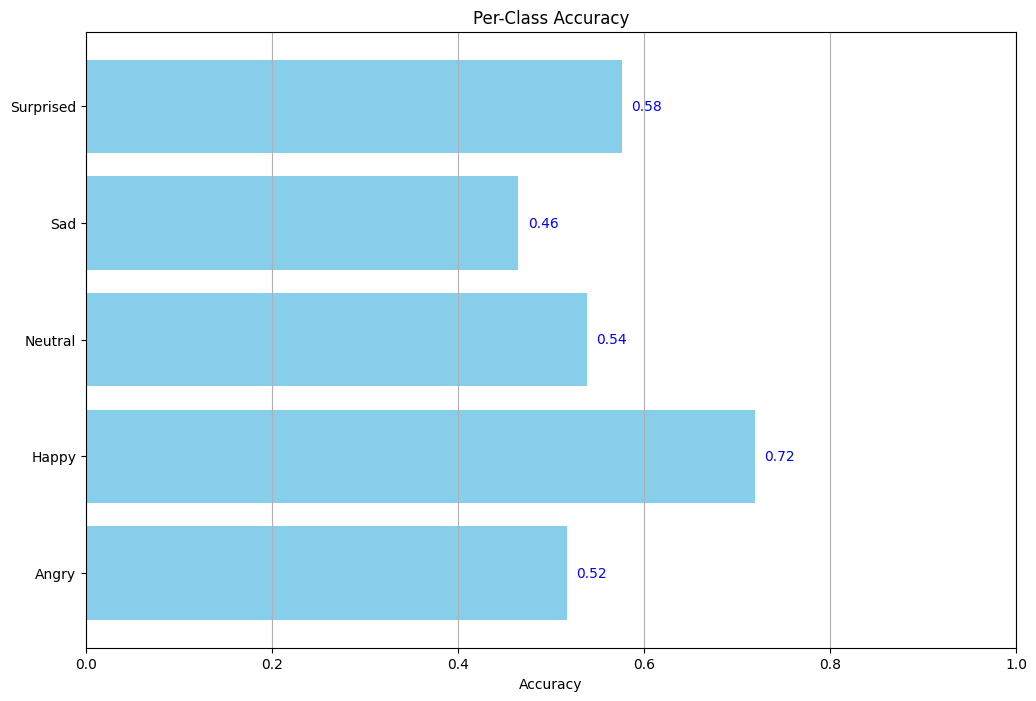

In [5]:
from src.models import ConvNet

model = ConvNet(num_features=5)
model_label = 'CNN'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizers = [optim.SGD]
optimizer_labels = ['SGD']

lr = 0.01

weight_decays = [None, 0.01, 0.001]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
trials_CNN = []

model.to(device)
initial_state = copy.deepcopy(model.state_dict())

for optimizer_index, optimizer in enumerate(optimizers):

    for criterion_index, criterion in enumerate(criterions):
        for weight_decay in weight_decays:
            print(f'\n--- testing model: {model_label} ---')
            print(f'optimizer: {optimizer_labels[optimizer_index]}')
            print(f'criterion: {criterion_labels[criterion_index]}')
            print(f'lr: {lr}')
            print(f'wd: {weight_decay}')
            print('----------------------------------')

            model.load_state_dict(initial_state)

            if weight_decay is not None:
                actual_optimizer = optimizer(
                    model.parameters(),
                    lr=lr,
                    weight_decay=weight_decay
                )
            else:
                actual_optimizer = optimizer(model.parameters(), lr=lr)

            history = train_model(model, criterion, actual_optimizer, train_loader, val_loader, early_stoping=True, epochs=60)

            best_epoch = get_best_epoch(history)
            plot_results(history)
            plot_confusion_matrix(model, val_loader, class_names, device)
            
            trials_CNN.append({
                'model': model_label,
                'optimizer': optimizer_labels[optimizer_index],
                'criterion': criterion_labels[criterion_index],
                'lr': lr,
                'history': history,
                'best_epoch': best_epoch,
                'history': history['weights'],
            })

            best = history['weights'][best_epoch - 1]
            name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
            torch.save(best, name)

            plot_per_class_accuracy(model, val_loader, class_names, device)


In [6]:
import gc
torch.cuda.empty_cache()
gc.collect()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 3.4 GB
Cached:    3.4 GB


### Custom VGG

Using device: cuda

--- testing model: Larger CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
wd: None
----------------------------------


Best Validation F1 Score 0.7342022123610337, is for epoch 40


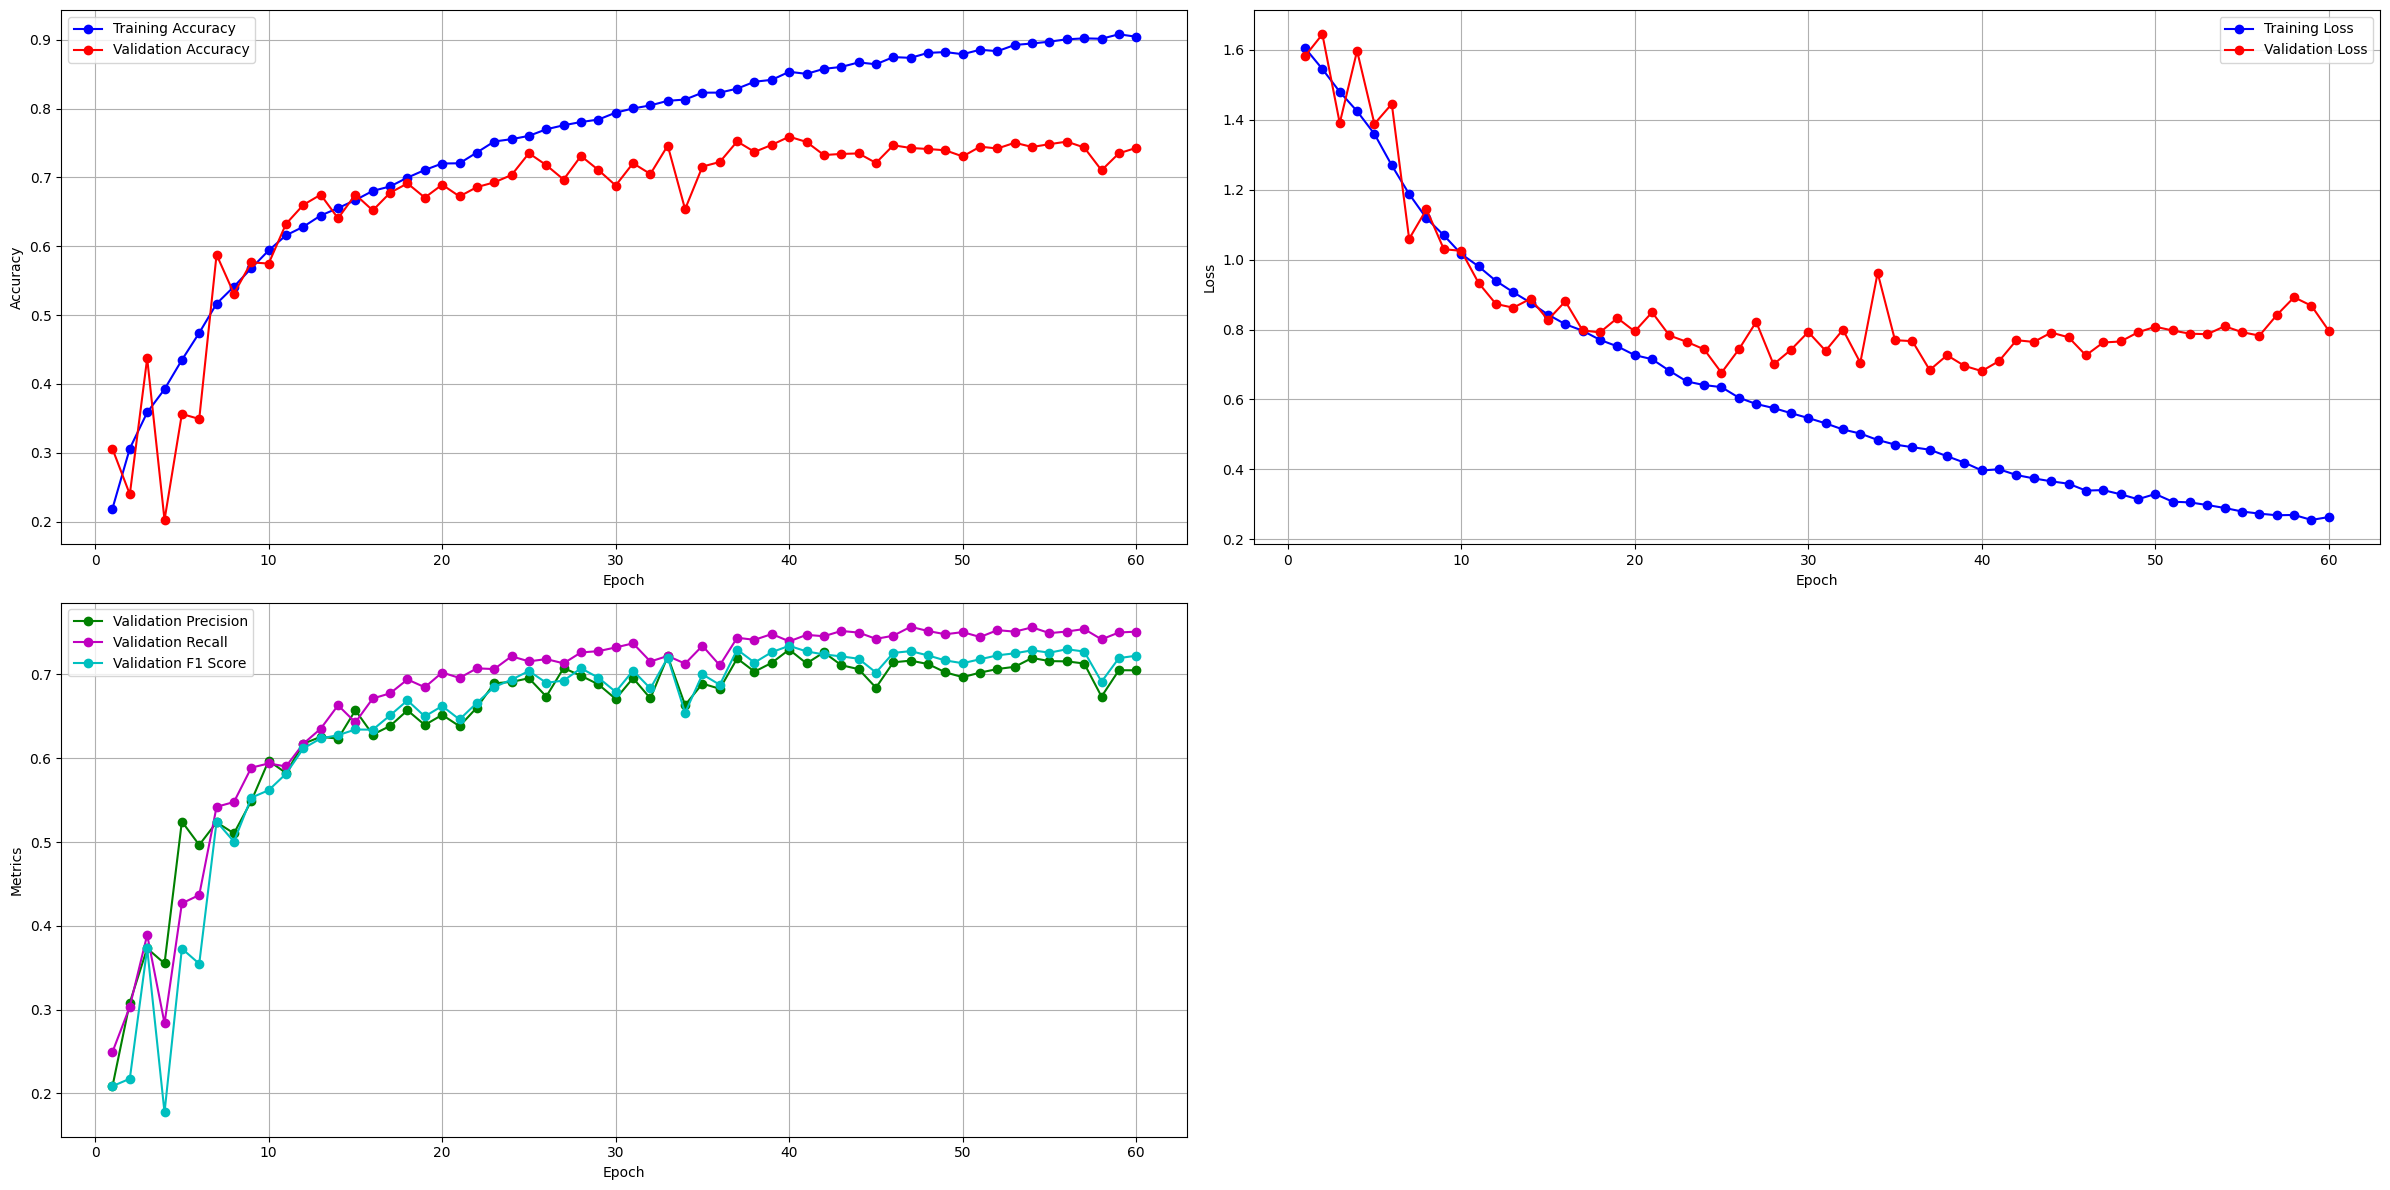

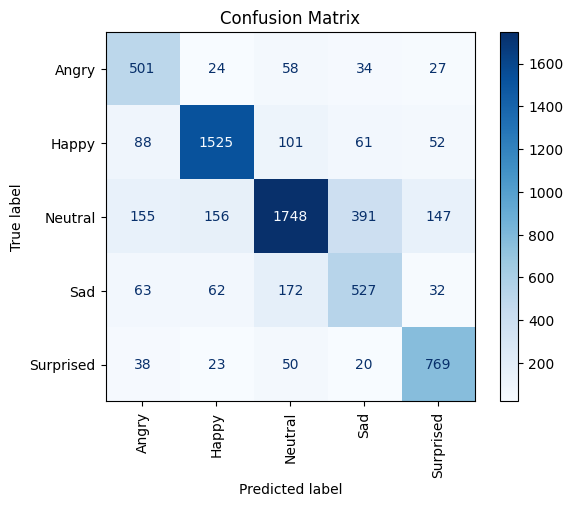

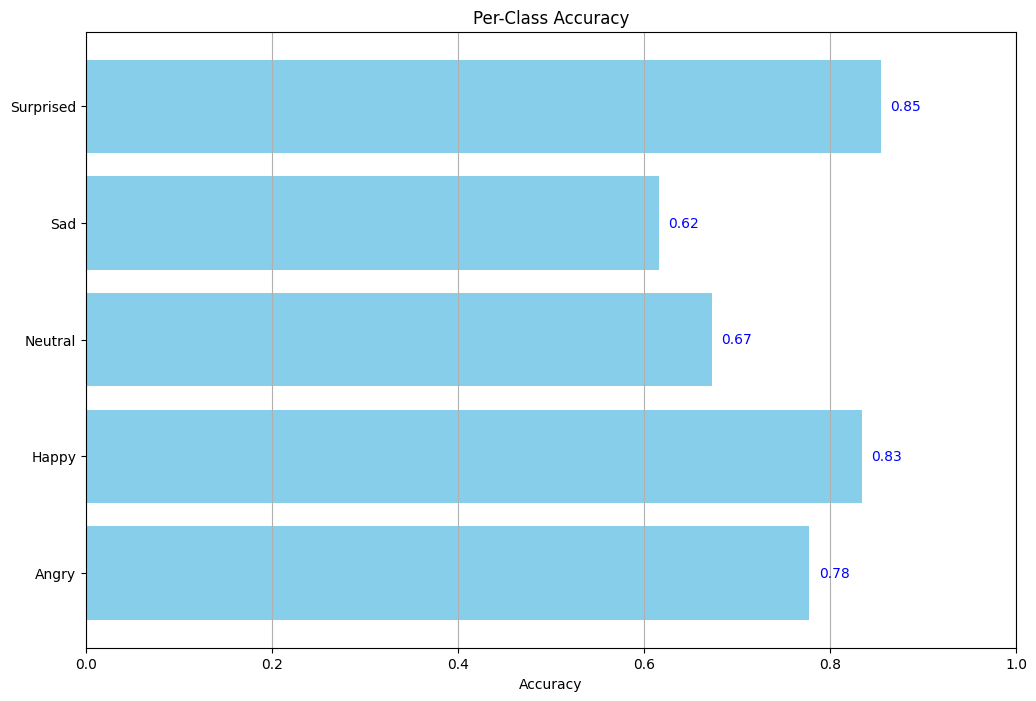


--- testing model: Larger CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
wd: 0.01
----------------------------------


KeyboardInterrupt: 

In [7]:
from src.models import ConvNetLarge

model = ConvNetLarge(num_features=5)
model_label = 'Larger CNN'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizer = optim.SGD
optimizer_labels = ['SGD']

lr = 0.1

weight_decays = [None, 0.01, 0.001]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
trials_CNN = []


initial_state = copy.deepcopy(model.state_dict())
model.to(device)

for criterion_index, criterion in enumerate(criterions):
    for weight_decay in weight_decays:
        print(f'\n--- testing model: {model_label} ---')
        print(f'optimizer: {optimizer_labels[optimizer_index]}')
        print(f'criterion: {criterion_labels[criterion_index]}')
        print(f'lr: {lr}')
        print(f'wd: {weight_decay}')
        print('----------------------------------')

        model.load_state_dict(initial_state)

        if weight_decay is not None:
            actual_optimizer = optimizer(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )
        else:
            actual_optimizer = optimizer(model.parameters(), lr=lr)

        history = train_model(
            model,
            criterion,
            actual_optimizer,
            train_loader,
            val_loader,
            epochs=60,
            early_stoping=True
        )

        best_epoch = get_best_epoch(history)
        plot_results(history)
        plot_confusion_matrix(model, val_loader, class_names, device)
        
        trials_CNN.append({
            'model': model_label,
            'optimizer': optimizer_labels[optimizer_index],
            'criterion': criterion_labels[criterion_index],
            'lr': lr,
            'history': history,
            'best_epoch': best_epoch,
            'history': history['weights'],
        })

        best = history['weights'][best_epoch - 1]
        name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
        torch.save(best, name)

        plot_per_class_accuracy(model, val_loader, class_names, device)


In [7]:
from src.models import ConvNetLarge

model = ConvNetLarge(num_features=5)
model_label = 'Larger CNN'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizer = optim.SGD
optimizer_labels = ['SGD']

lr = 0.1

weight_decays = [0.01]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
trials_CNN = []


initial_state = copy.deepcopy(model.state_dict())
model.to(device)

for criterion_index, criterion in enumerate(criterions):
    for weight_decay in weight_decays:
        print(f'\n--- testing model: {model_label} ---')
        print(f'optimizer: {optimizer_labels[0]}')
        print(f'criterion: {criterion_labels[criterion_index]}')
        print(f'lr: {lr}')
        print(f'wd: {weight_decay}')
        print('----------------------------------')

        model.load_state_dict(initial_state)

        if weight_decay is not None:
            actual_optimizer = optimizer(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )
        else:
            actual_optimizer = optimizer(model.parameters(), lr=lr)

        history = train_model(
            model,
            criterion,
            actual_optimizer,
            train_loader,
            val_loader,
            epochs=40,
            early_stoping=True
        )

        best_epoch = get_best_epoch(history)
        plot_results(history)
        plot_confusion_matrix(model, val_loader, class_names, device)
        
        trials_CNN.append({
            'model': model_label,
            'optimizer': optimizer_labels[0],
            'criterion': criterion_labels[criterion_index],
            'lr': lr,
            'history': history,
            'best_epoch': best_epoch,
            'history': history['weights'],
        })

        best = history['weights'][best_epoch - 1]
        name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
        torch.save(best, name)

        plot_per_class_accuracy(model, val_loader, class_names, device)


Using device: cuda

--- testing model: Larger CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
wd: 0.01
----------------------------------


KeyboardInterrupt: 

In [4]:
import gc
torch.cuda.empty_cache()
gc.collect()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Resnet

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Using device: cuda

--- testing model: Resnet ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


Best Validation F1 Score 0.625185954120895, is for epoch 58


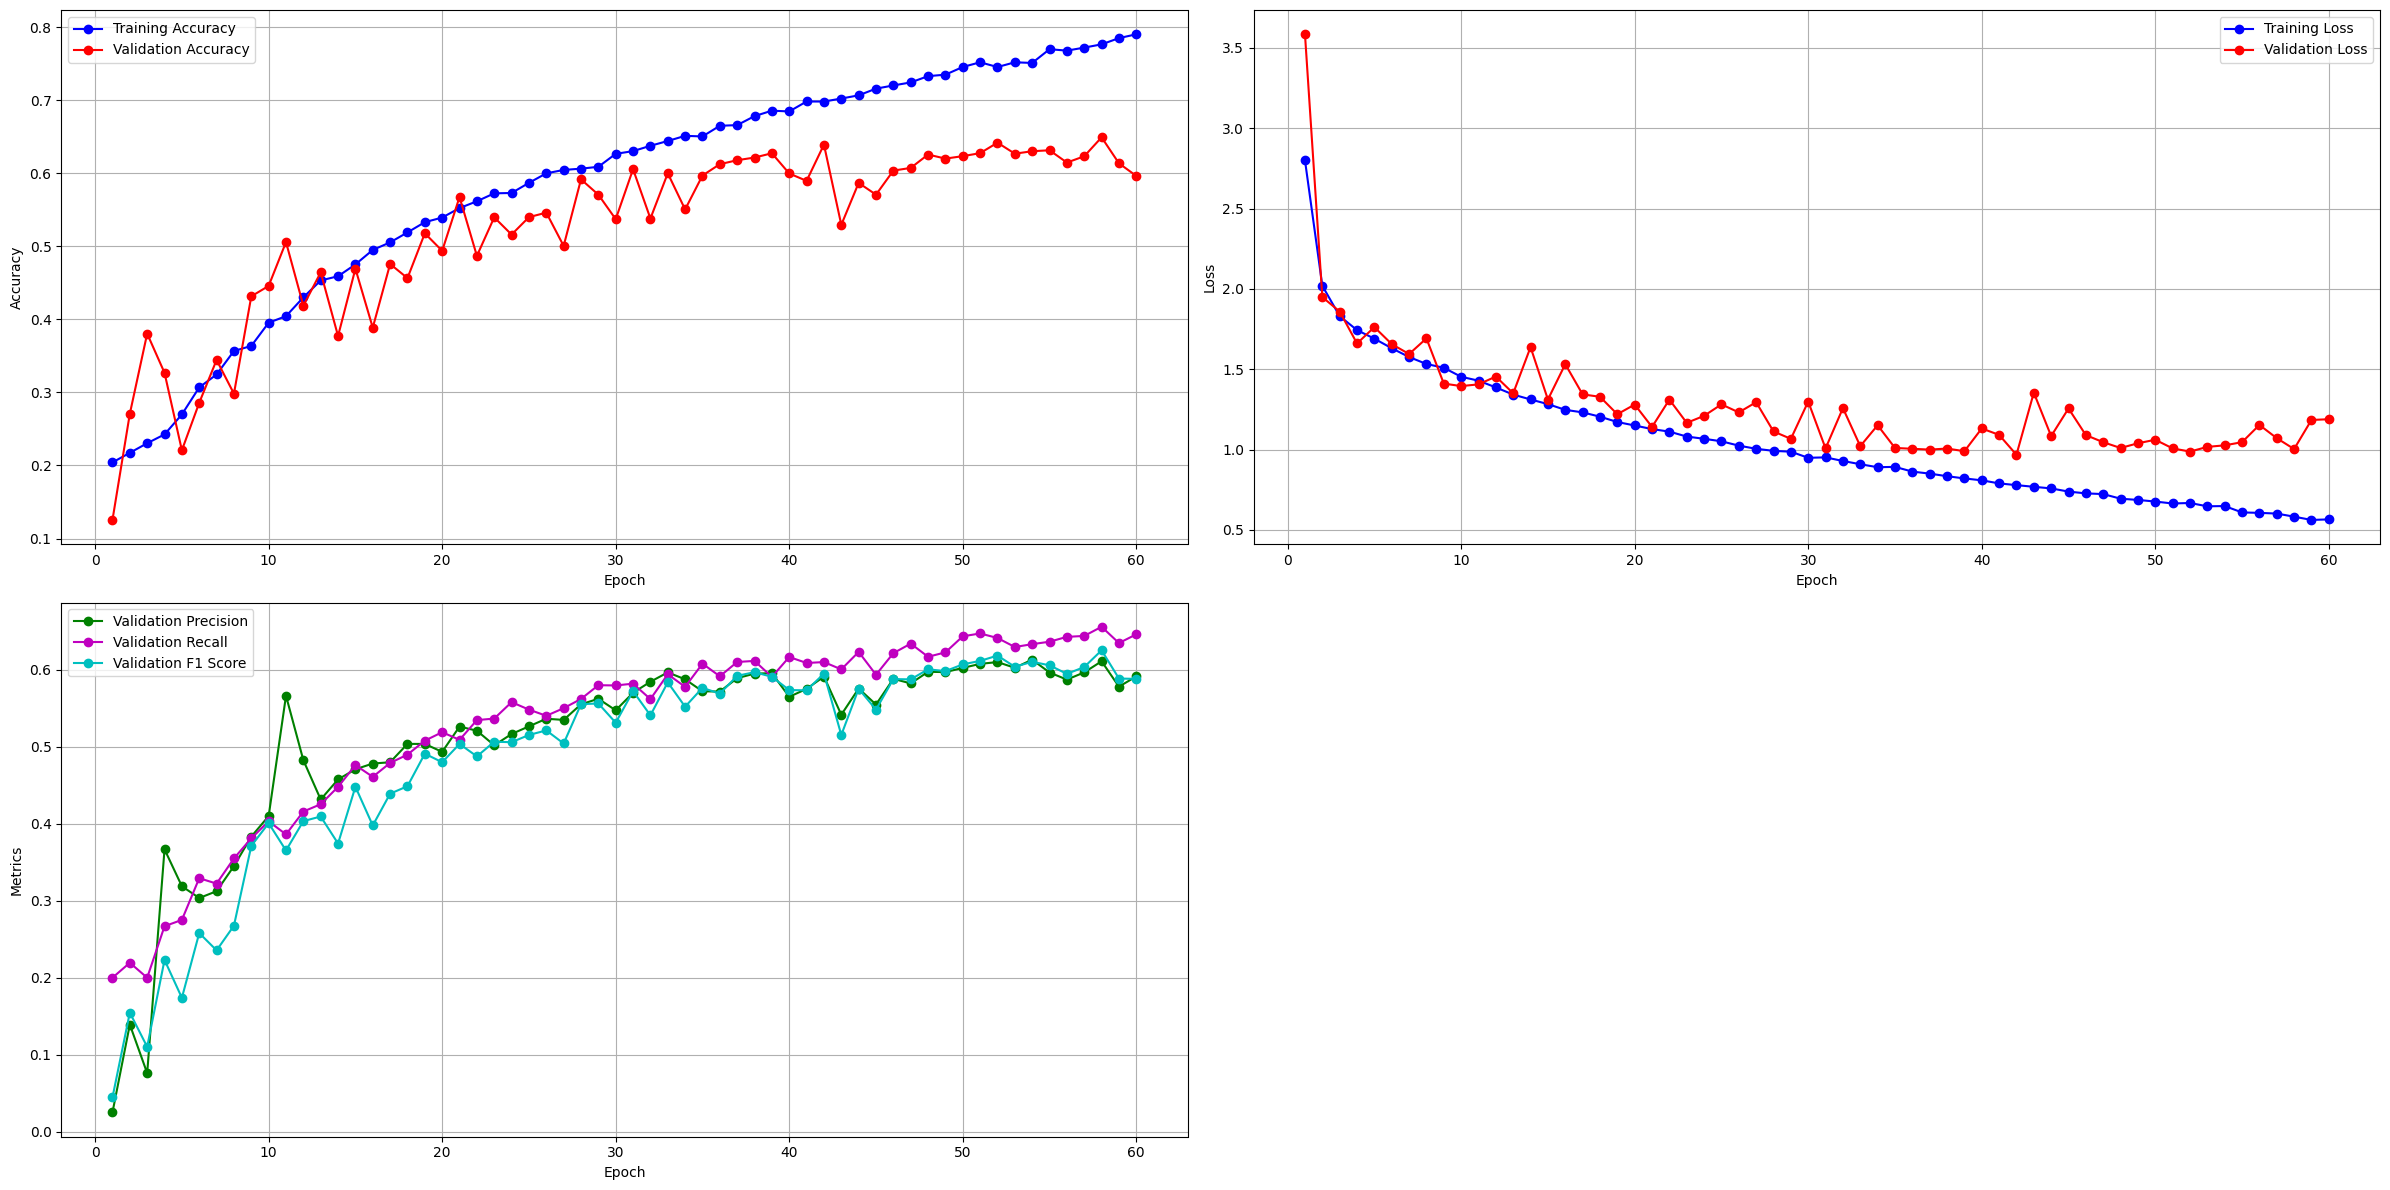

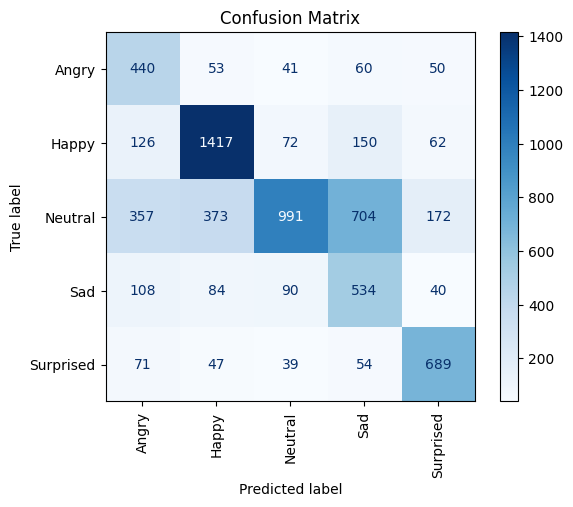

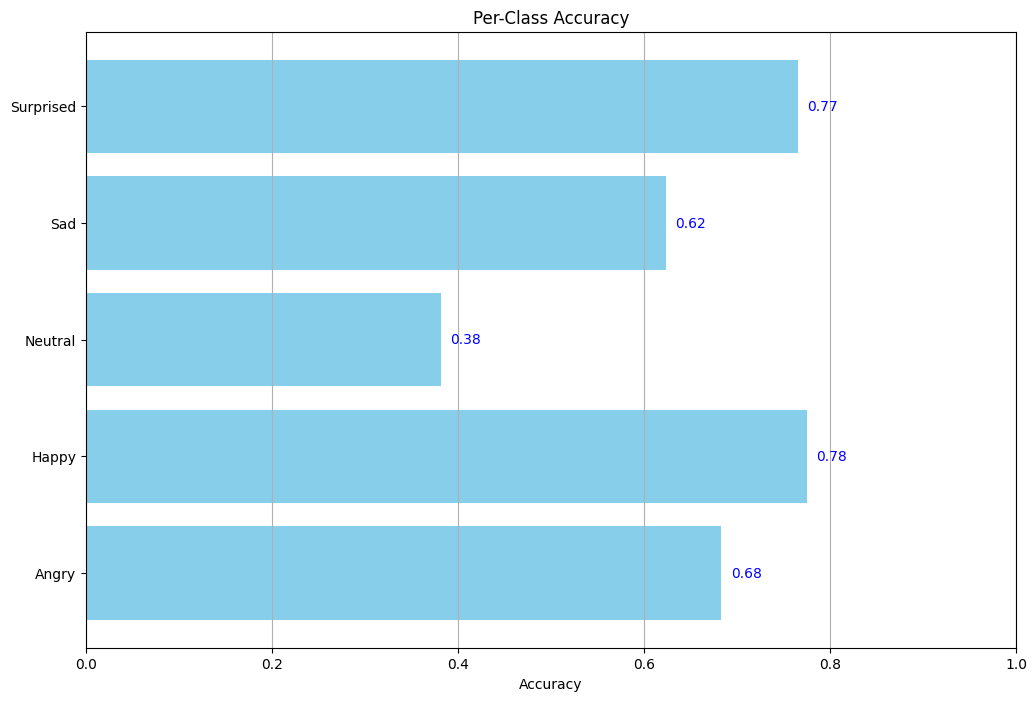


--- testing model: Resnet ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


Best Validation F1 Score 0.6532790928127511, is for epoch 56


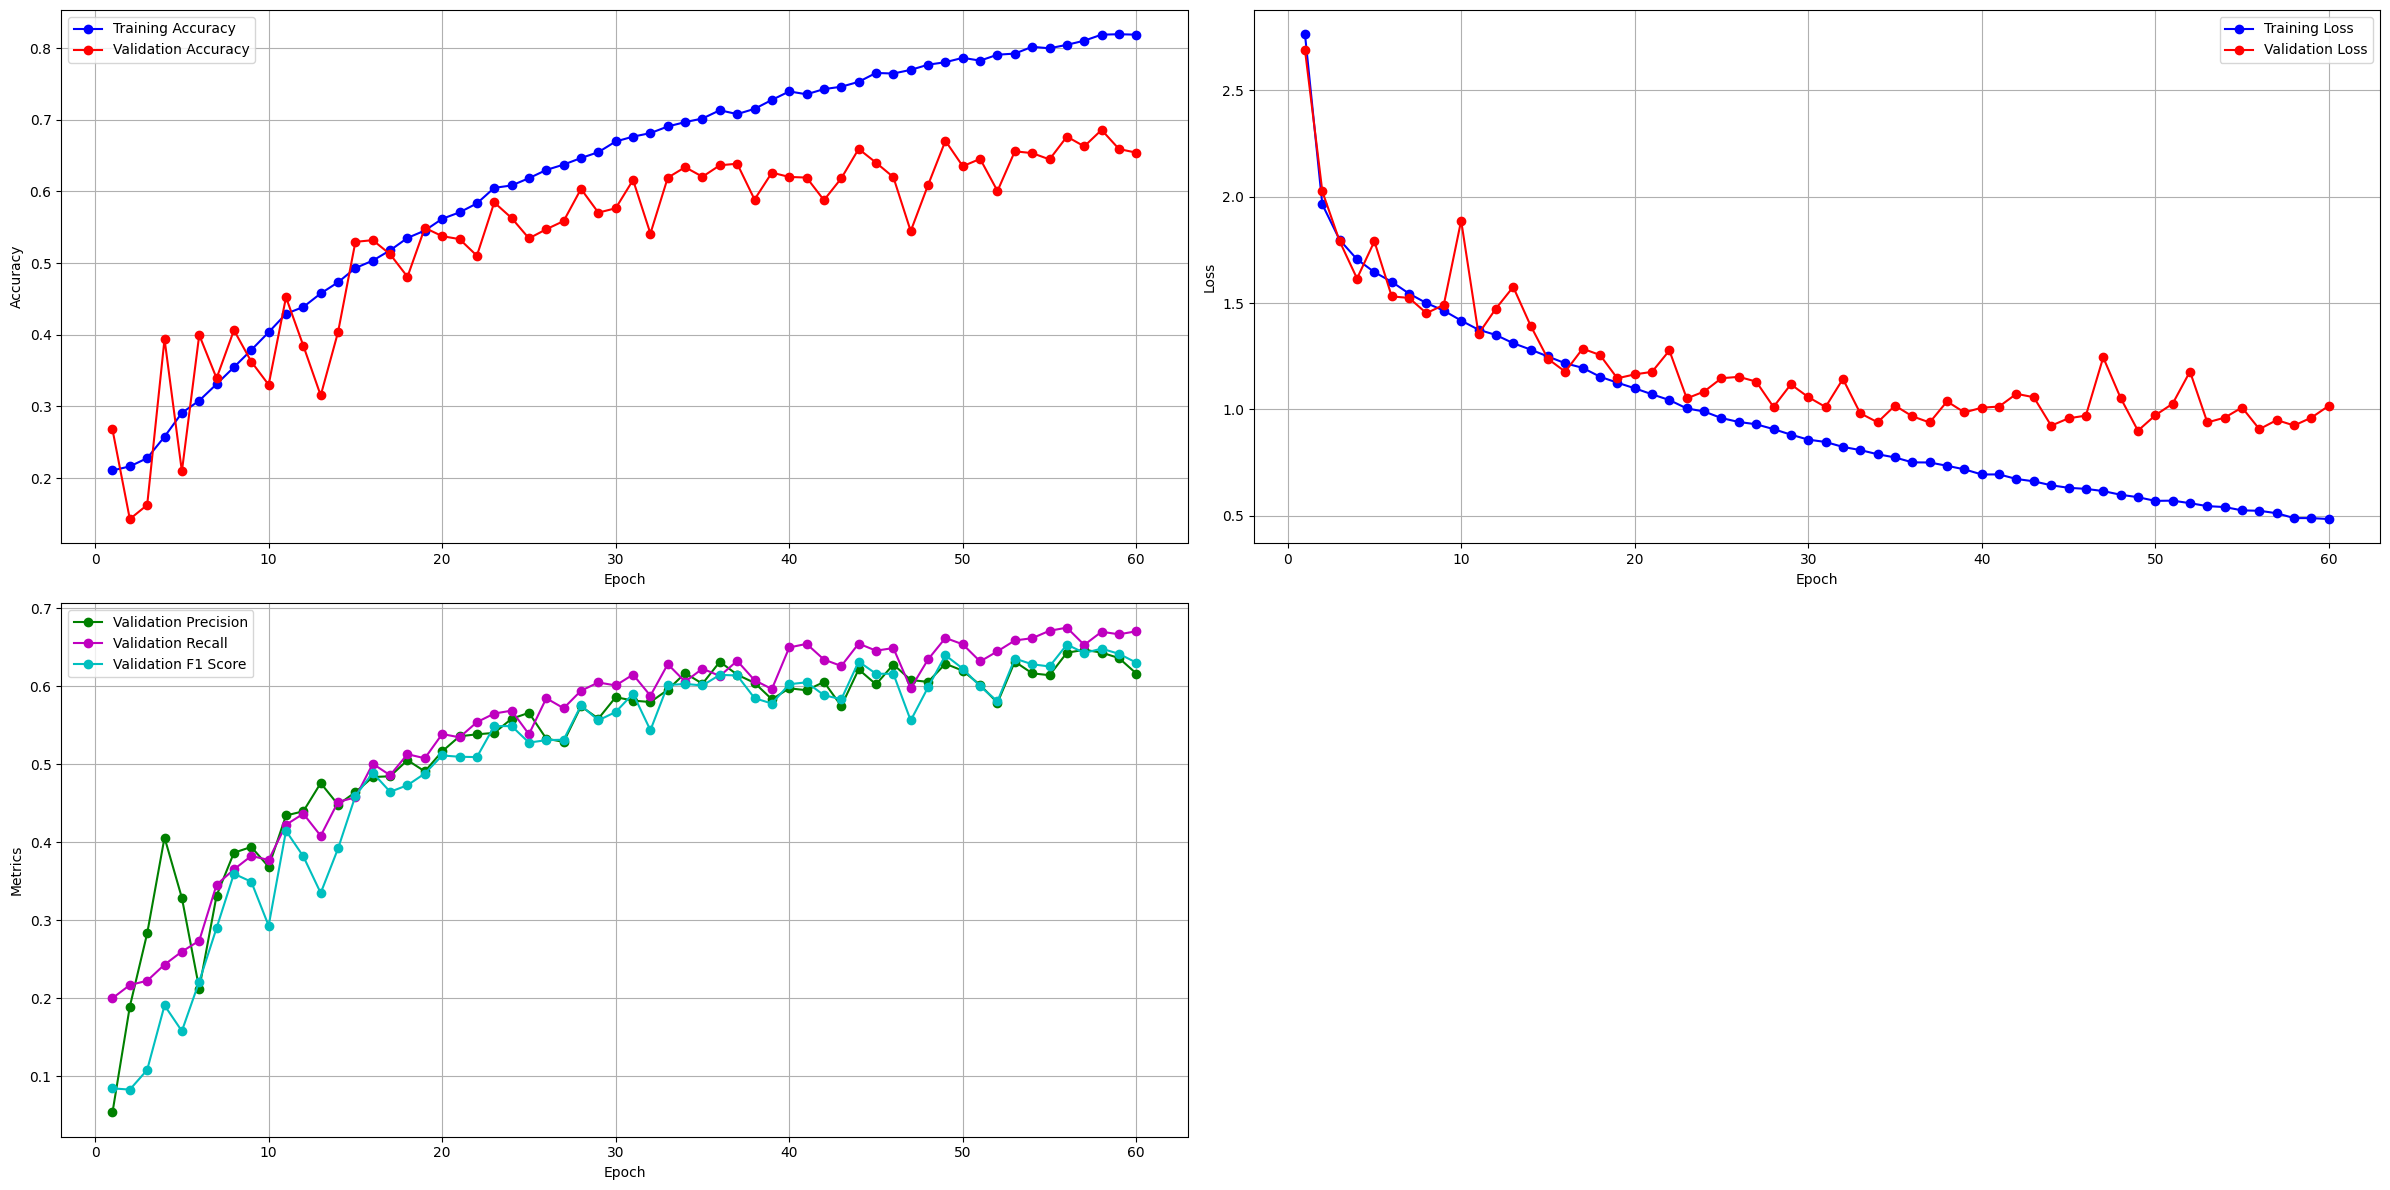

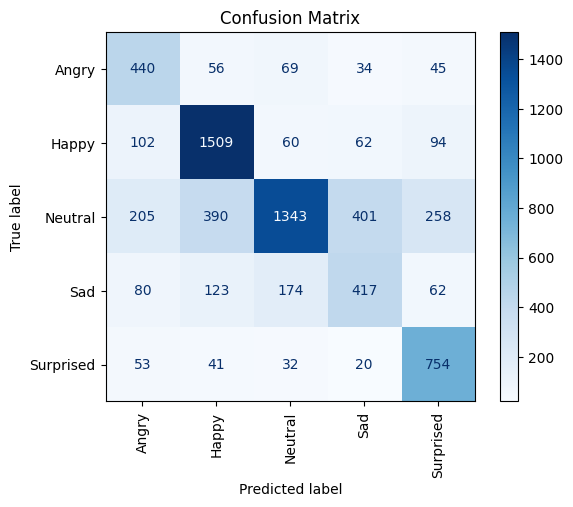

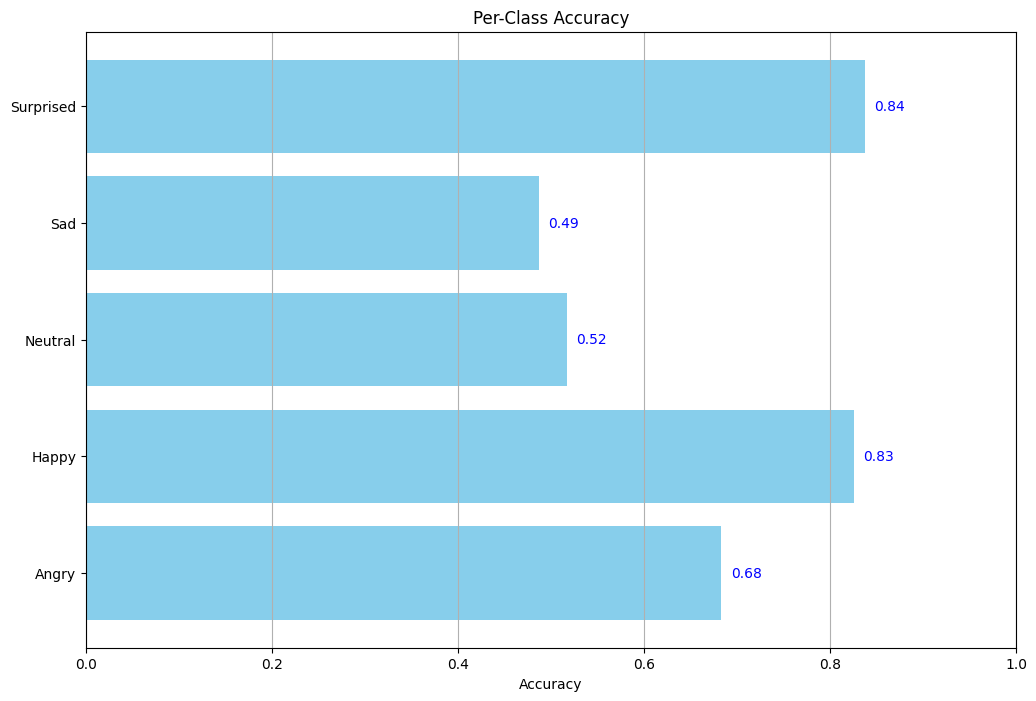


--- testing model: Resnet ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


KeyboardInterrupt: 

In [5]:
import copy

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

model = resnet
model_label = 'Resnet'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizer = optim.SGD
optimizer_label = 'SGD'

lr = 0.01
weight_decays = [None, 0.01, 0.001]

trials_resnet = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
initial_state = copy.deepcopy(model.state_dict())

for criterion_index, criterion in enumerate(criterions):
    for weight_decay in weight_decays:
        print(f'\n--- testing model: {model_label} ---')
        print(f'optimizer: {optimizer_label}')
        print(f'criterion: {criterion_labels[criterion_index]}')
        print(f'lr: {lr}')
        print('----------------------------------')

        model.load_state_dict(initial_state)

        if weight_decay is not None:
            actual_optimizer = optimizer(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )
        else:
            actual_optimizer = optimizer(model.parameters(), lr=lr)

        history = train_model(
            model,
            criterion,
            actual_optimizer,
            train_loader,
            val_loader,
            epochs=60,
            early_stoping=True
        )

        best_epoch = get_best_epoch(history)
        plot_results(history)
        plot_confusion_matrix(model, val_loader, class_names, device)
        
        trials_resnet.append({
            'model': model_label,
            'optimizer': optimizer_label,
            'criterion': criterion_labels[criterion_index],
            'lr': lr,
            'history': history,
            'best_epoch': best_epoch,
            'history': history['weights'],
        })

        best = history['weights'][best_epoch - 1]
        name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
        torch.save(best, name)

        plot_per_class_accuracy(model, val_loader, class_names, device)


In [4]:
import copy

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

model = resnet
model_label = 'Resnet'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizer = optim.SGD
optimizer_label = 'SGD'

lr = 0.01
weight_decays = [0.001]

trials_resnet = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
initial_state = copy.deepcopy(model.state_dict())

for criterion_index, criterion in enumerate(criterions):
    for weight_decay in weight_decays:
        print(f'\n--- testing model: {model_label} ---')
        print(f'optimizer: {optimizer_label}')
        print(f'criterion: {criterion_labels[criterion_index]}')
        print(f'lr: {lr}')
        print('----------------------------------')

        model.load_state_dict(initial_state)

        if weight_decay is not None:
            actual_optimizer = optimizer(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )
        else:
            actual_optimizer = optimizer(model.parameters(), lr=lr)

        history = train_model(
            model,
            criterion,
            actual_optimizer,
            train_loader,
            val_loader,
            epochs=60,
            early_stoping=True
        )

        best_epoch = get_best_epoch(history)
        plot_results(history)
        plot_confusion_matrix(model, val_loader, class_names, device)
        
        trials_resnet.append({
            'model': model_label,
            'optimizer': optimizer_label,
            'criterion': criterion_labels[criterion_index],
            'lr': lr,
            'history': history,
            'best_epoch': best_epoch,
            'history': history['weights'],
        })

        best = history['weights'][best_epoch - 1]
        name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
        torch.save(best, name)

        plot_per_class_accuracy(model, val_loader, class_names, device)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


Using device: cuda

--- testing model: Resnet ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


KeyboardInterrupt: 

In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.4 GB


### VGG

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


Using device: cuda

--- testing model: VGG-11 ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
----------------------------------


Best Validation F1 Score 0.7239055038789954, is for epoch 25


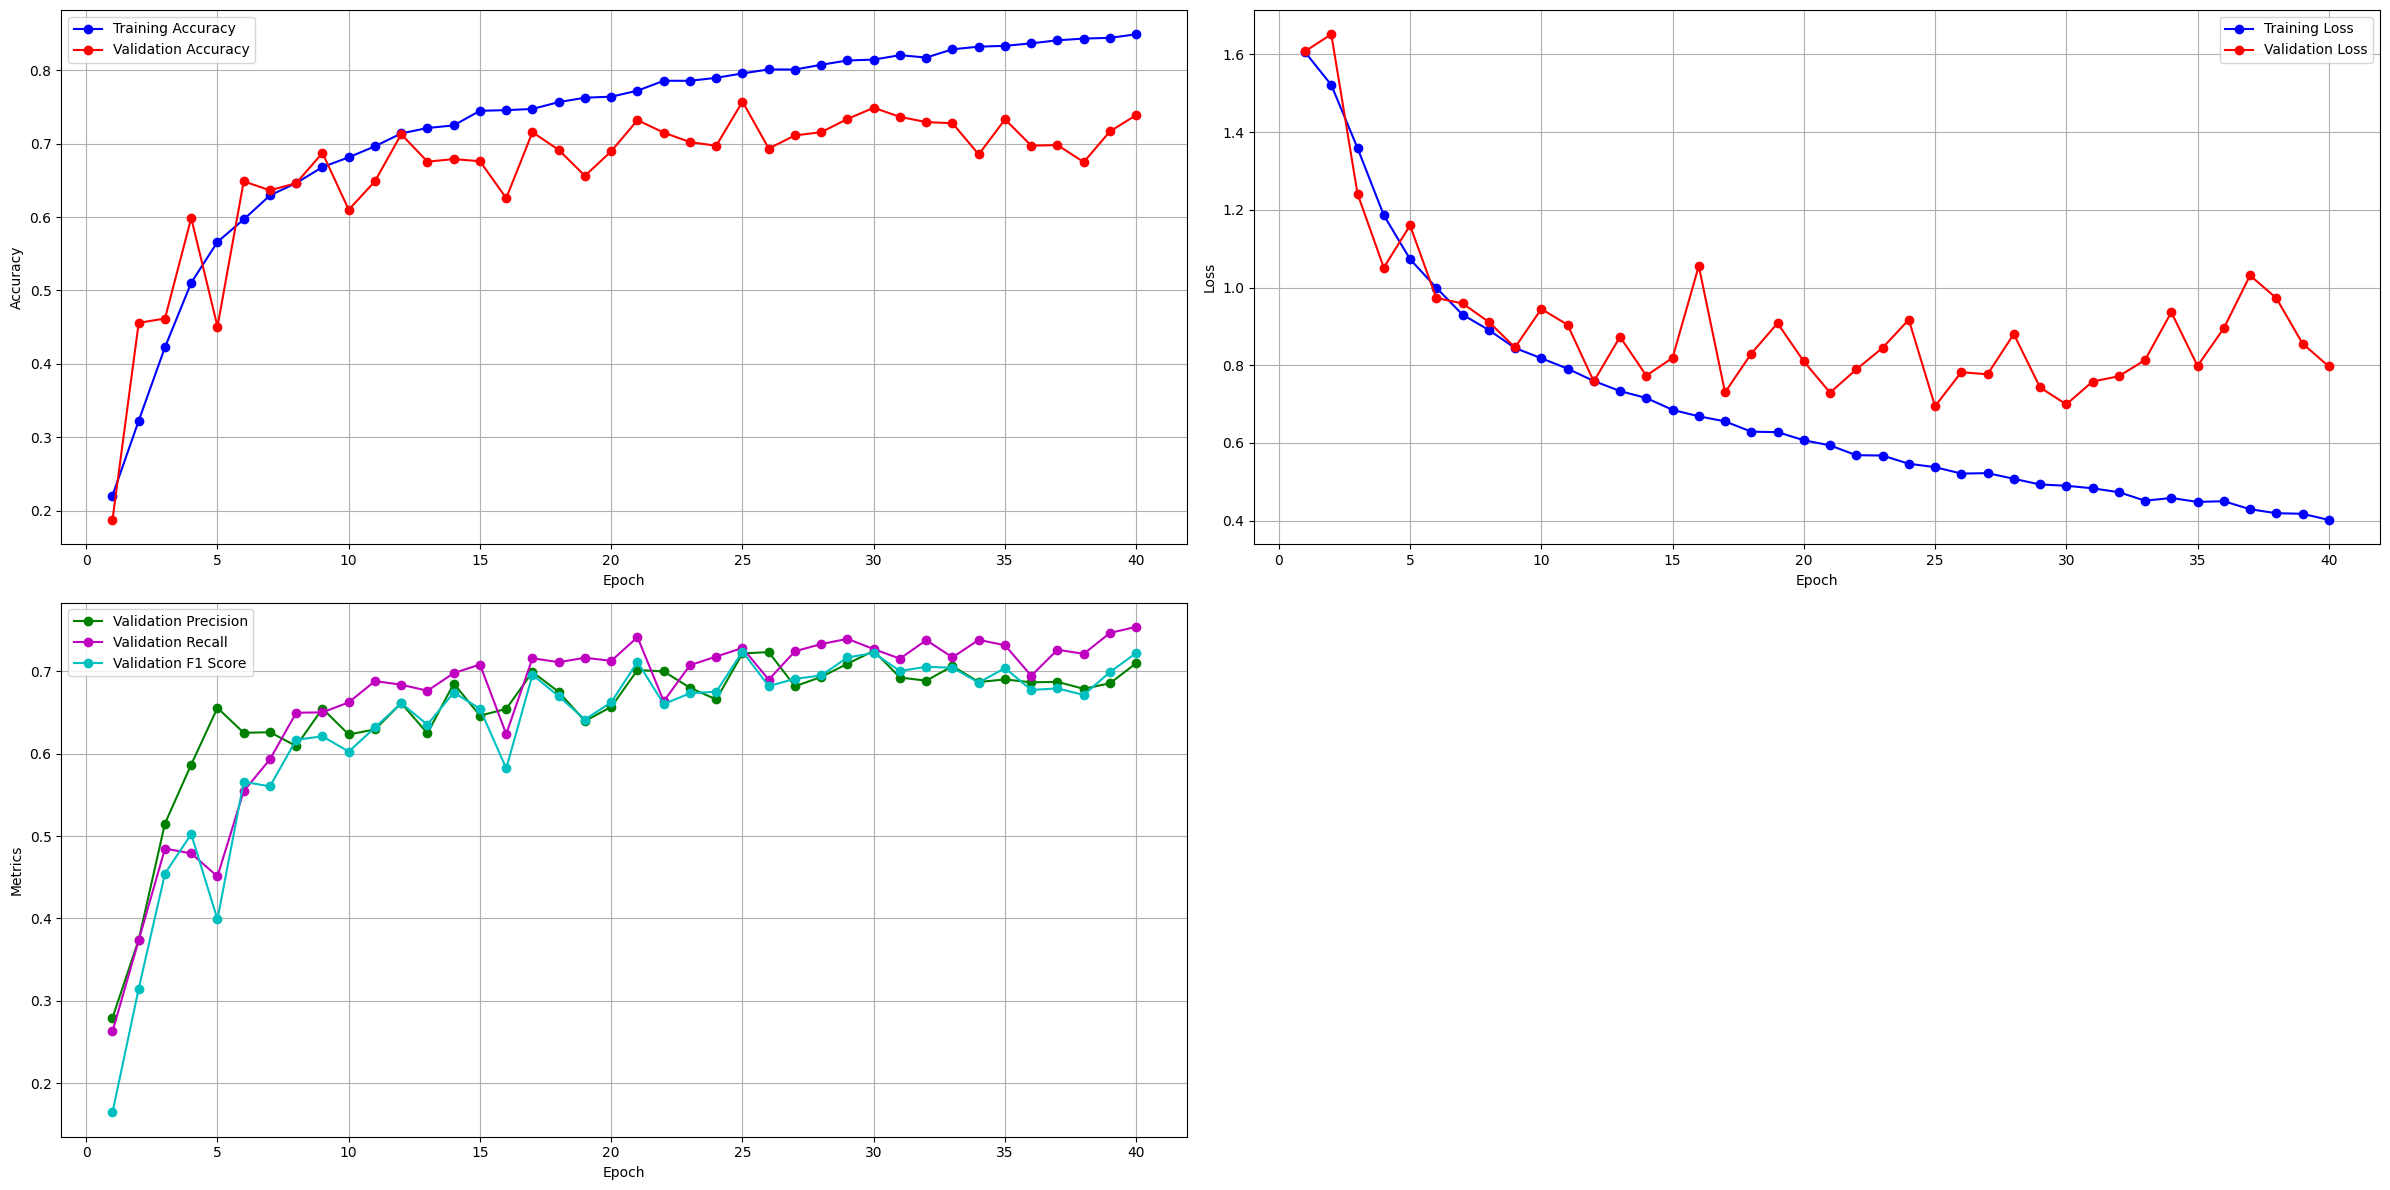

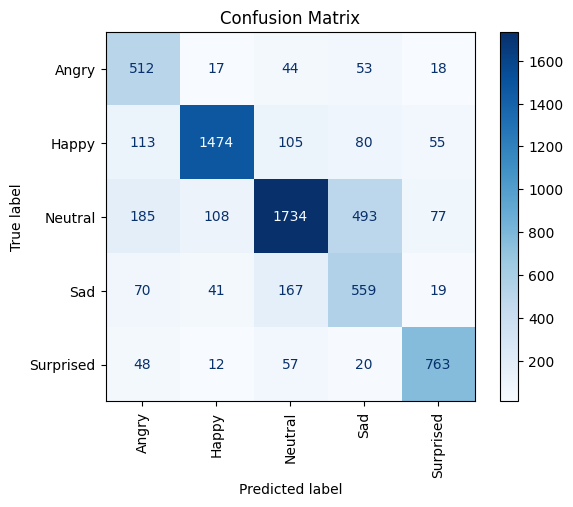

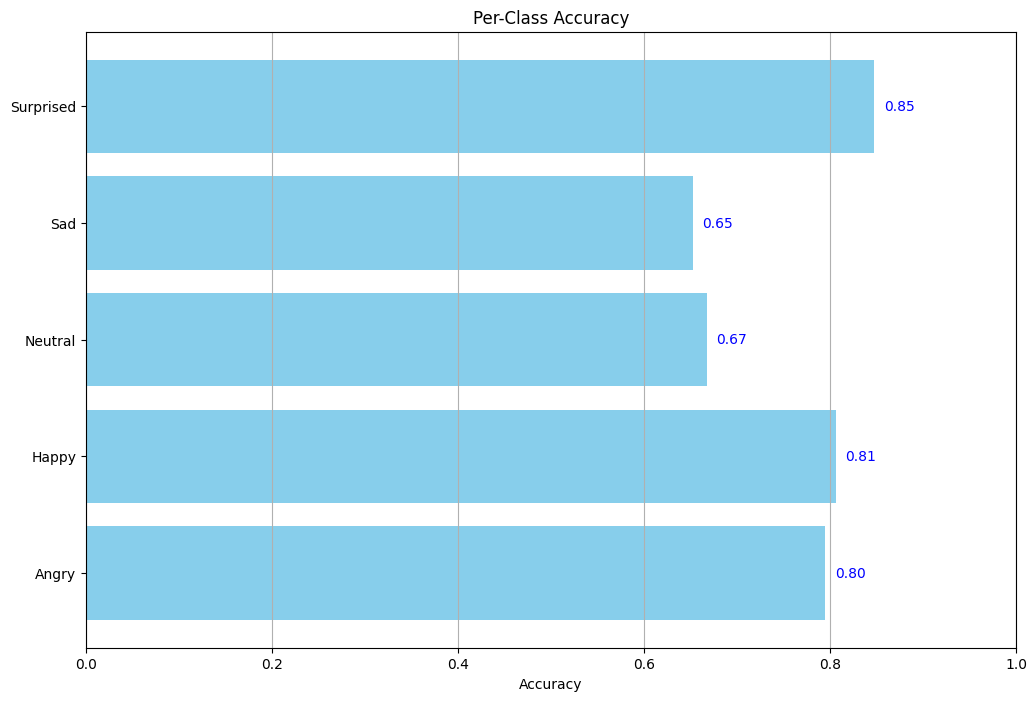


--- testing model: VGG-11 ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
----------------------------------


KeyboardInterrupt: 

In [4]:
import copy

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', weights=None)

# Modify the first convolutional layer to accept grayscale images
# Original: nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Modify the classifier to output 6 classes instead of 1000
# The original VGG has:
model.classifier[-1] = nn.Linear(4096, 5)

model_label = 'VGG-11'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizer = optim.SGD
optimizer_label = 'SGD'

lr = 0.1
weight_decays = [None, 0.01, 0.001]

trials_vgg = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
initial_state = copy.deepcopy(model.state_dict())

for criterion_index, criterion in enumerate(criterions):
    for weight_decay in weight_decays:
        print(f'\n--- testing model: {model_label} ---')
        print(f'optimizer: {optimizer_label}')
        print(f'criterion: {criterion_labels[criterion_index]}')
        print(f'lr: {lr}')
        print('----------------------------------')

        model.load_state_dict(initial_state)

        if weight_decay is not None:
            actual_optimizer = optimizer(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )
        else:
            actual_optimizer = optimizer(model.parameters(), lr=lr)

        history = train_model(
            model,
            criterion,
            actual_optimizer,
            train_loader,
            val_loader,
            epochs=40,
            early_stoping=True
        )

        best_epoch = get_best_epoch(history)
        plot_results(history)
        plot_confusion_matrix(model, val_loader, class_names, device)
        
        trials_vgg.append({
            'model': model_label,
            'optimizer': optimizer_label,
            'criterion': criterion_labels[criterion_index],
            'lr': lr,
            'history': history,
            'best_epoch': best_epoch,
            'history': history['weights'],
        })

        best = history['weights'][best_epoch - 1]
        name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
        torch.save(best, name)

        plot_per_class_accuracy(model, val_loader, class_names, device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Using device: cuda

--- testing model: VGG-11 ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
----------------------------------


Best Validation F1 Score 0.734473084030488, is for epoch 36


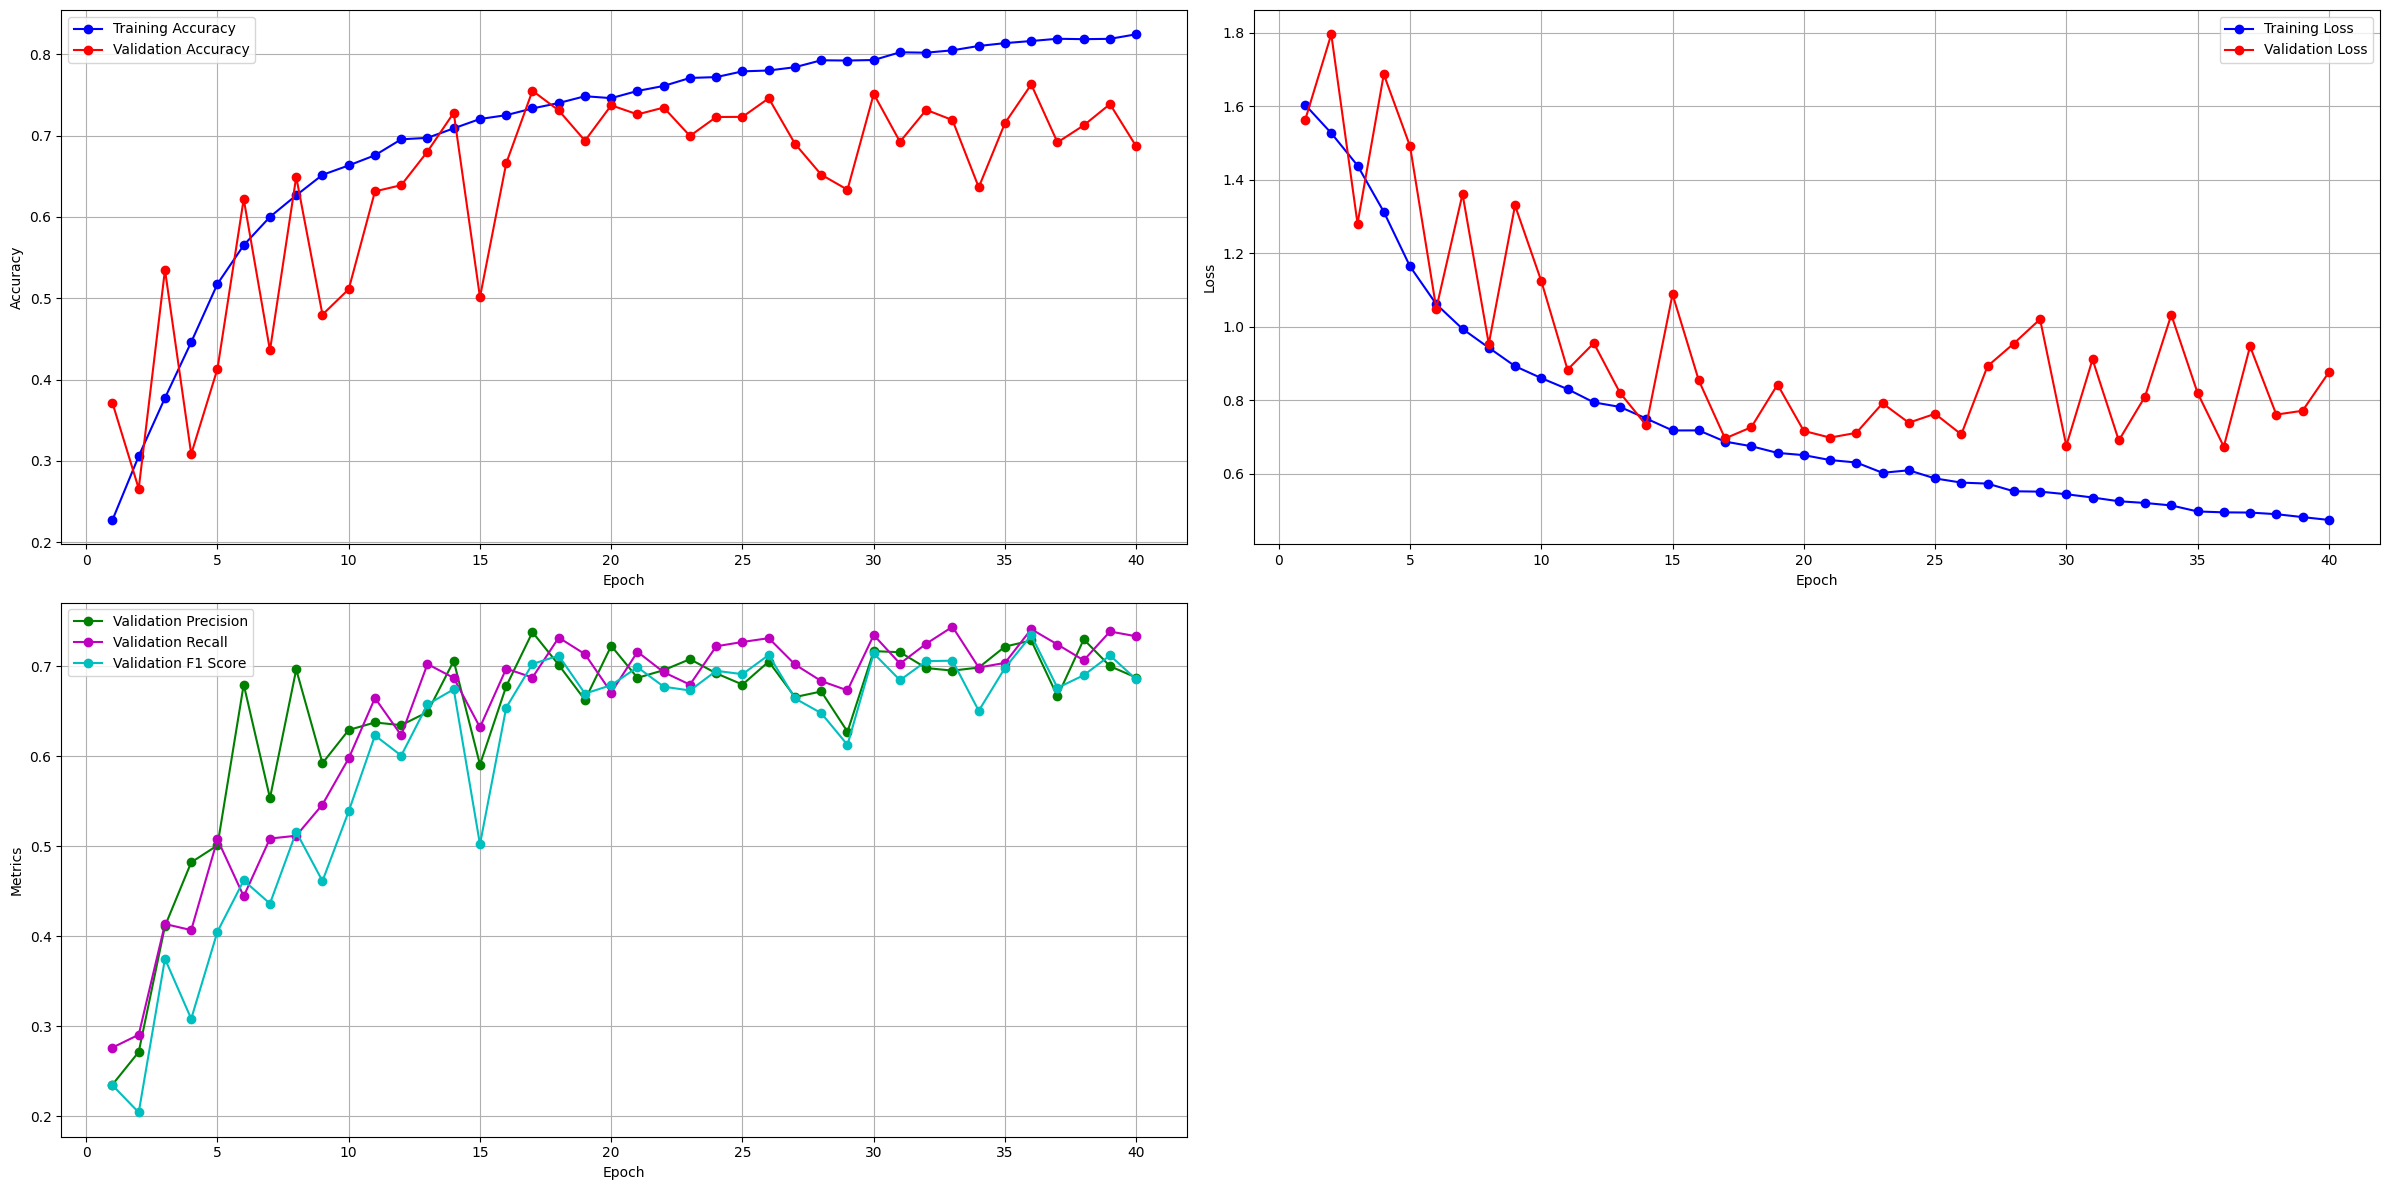

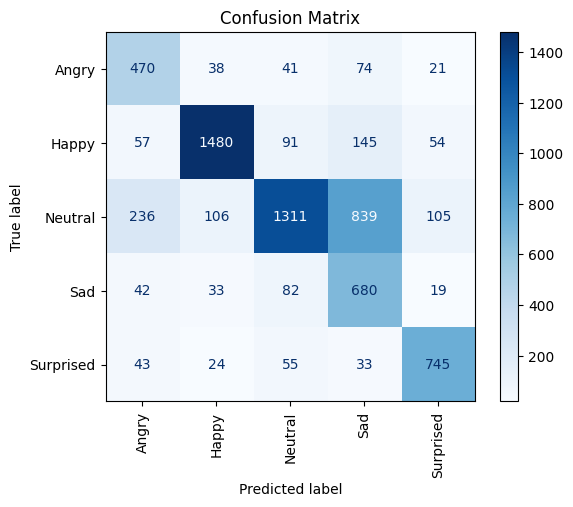

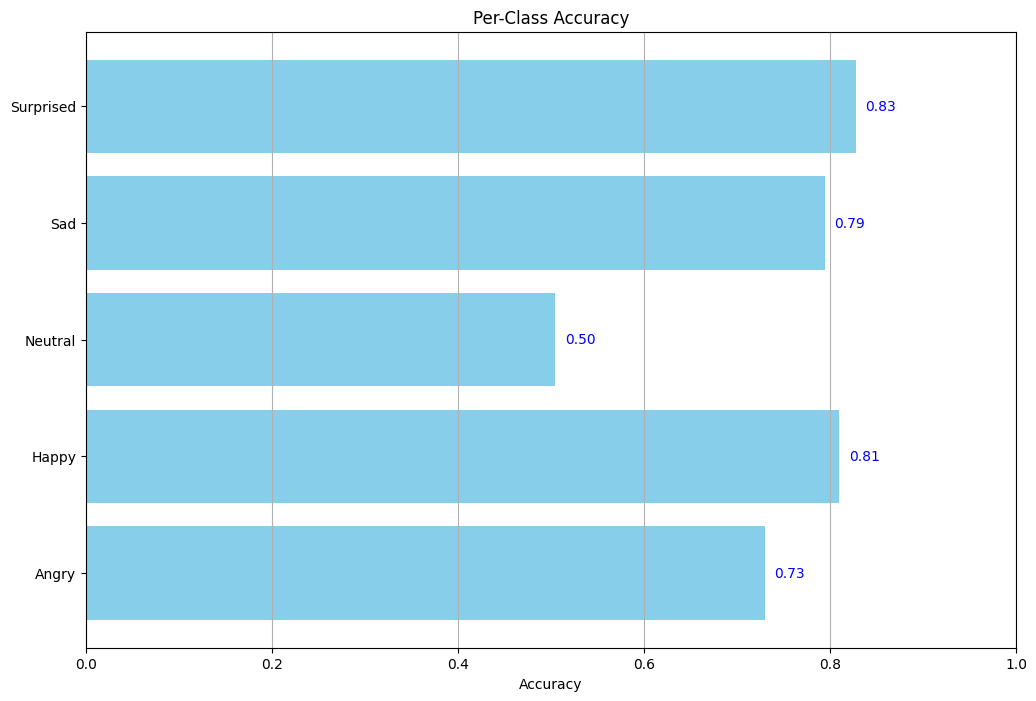

In [5]:
import copy

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', weights=None)

# Modify the first convolutional layer to accept grayscale images
# Original: nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Modify the classifier to output 6 classes instead of 1000
# The original VGG has:
model.classifier[-1] = nn.Linear(4096, 5)

model_label = 'VGG-11'
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizer = optim.SGD
optimizer_label = 'SGD'

lr = 0.1
weight_decays = [0.001]

trials_vgg = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
initial_state = copy.deepcopy(model.state_dict())

for criterion_index, criterion in enumerate(criterions):
    for weight_decay in weight_decays:
        print(f'\n--- testing model: {model_label} ---')
        print(f'optimizer: {optimizer_label}')
        print(f'criterion: {criterion_labels[criterion_index]}')
        print(f'lr: {lr}')
        print('----------------------------------')

        model.load_state_dict(initial_state)

        if weight_decay is not None:
            actual_optimizer = optimizer(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )
        else:
            actual_optimizer = optimizer(model.parameters(), lr=lr)

        history = train_model(
            model,
            criterion,
            actual_optimizer,
            train_loader,
            val_loader,
            epochs=40,
            early_stoping=True
        )

        best_epoch = get_best_epoch(history)
        plot_results(history)
        plot_confusion_matrix(model, val_loader, class_names, device)
        
        trials_vgg.append({
            'model': model_label,
            'optimizer': optimizer_label,
            'criterion': criterion_labels[criterion_index],
            'lr': lr,
            'history': history,
            'best_epoch': best_epoch,
            'history': history['weights'],
        })

        best = history['weights'][best_epoch - 1]
        name = './exports/trial2/' + model_label + '_' + 'lr' + str(lr).replace('.', '') + 'wd' + str(weight_decay).replace('.', '') + '.pt'
        torch.save(best, name)

        plot_per_class_accuracy(model, val_loader, class_names, device)